In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import argparse
import os
import matplotlib.ticker as ticker

from azureml.core.run import Run
from azureml.core import Workspace, Dataset
from tf_agents.environments import tf_py_environment, py_environment, utils
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import EpsilonGreedyPolicy, random_tf_policy, tf_policy, tf_py_policy, py_policy
from tf_agents.policies.q_policy import QPolicy
from tf_agents.policies.boltzmann_policy import BoltzmannPolicy
from tf_agents.trajectories import trajectory, Trajectory, PolicyStep, time_step as ts
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.metrics import tf_metrics
from tf_agents.specs import array_spec
from tf_agents.drivers import dynamic_step_driver
from tf_agents.utils import common
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from helper_functions import *
from environment_functions import *

In [34]:
def train_agent(n_iterations, policy, collect_driver):
    time_step = None
    policy_state = policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    
    for iteration in range(n_iterations):
        current_metrics = []
        
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)
        all_train_loss.append(train_loss.loss.numpy())

        for i in range(len(train_metrics)):
            current_metrics.append(train_metrics[i].result().numpy())
            
        all_metrics.append(current_metrics)
        
        if iteration % 1000 == 0:
            print("\nIteration: {}, loss:{:.2f}".format(iteration, train_loss.loss.numpy()))
            print('Train step counter: {}, epsilon: {:.3f}'.format(int(train_step_counter), epsilon_fn(train_step_counter)))
            
            for i in range(len(train_metrics)):
                print('{}: {}'.format(train_metrics[i].name, train_metrics[i].result().numpy()))
                
                if type(i) == tf_metrics.AverageReturnMetric:
                    run.log('Training avg reward', train_metrics[i].result().numpy())

In [35]:
# Env settings
num_actions = (100-20) / 2
num_features = 33  # TODO: Make dynamic

# Set seed for reproducability
seed = 123
tf.random.set_seed(seed)

In [36]:
dpc_game = DynamicPricingCompetition()
simulator = CreateAirlineSimulation()
environment = AirlineEnvironment(dpc_game, simulator, num_features, num_actions, 
                                 discount=1.0, min_action=20, action_step=2, comp_sellout_price=100, 
                                 early_termination_penalty=10, price_diff_penalty=0.1, loadactor_diff_penalty=0.4,
                                 stock_remainder_penalty=50)
utils.validate_py_environment(environment, episodes=5)

# Create train and evaluate env
train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(environment)

dpc_game.reset()
dpc_game.competition_results_df = pd.DataFrame()

In [37]:
init = tf.keras.initializers.HeUniform()
layer1 = Dense(units=20, input_shape=(num_features,), activation='relu', 
               kernel_initializer=init, name='hidden_layer1')
layer2 = Dense(units=40, activation='relu', kernel_initializer=init, name='hidden_layer2')
layer3 = Dense(units=num_actions, activation=None, kernel_initializer=init)
q_net = sequential.Sequential([layer1, layer2, layer3])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [38]:
train_step_counter = tf.Variable(0)

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                initial_learning_rate=100., 
                decay_steps=1000000,
                end_learning_rate=1.)

agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
    gamma=1.,
    boltzmann_temperature=lambda: epsilon_fn(train_step_counter),
    epsilon_greedy=None,
    train_step_counter=train_step_counter
)

agent.initialize()

In [39]:
# replay buffer and driver for training
replay_buffer = TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=1,
    max_length=10000
)

replay_buffer_observer = replay_buffer.add_batch
train_metrics = [tf_metrics.AverageReturnMetric()]

# create policies
train_policy = CustomOurStrategyPolicy(train_env.time_step_spec(), train_env.action_spec(), ())
qpolicy = QPolicy(train_env.time_step_spec(), train_env.action_spec(), q_net)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=1)

In [43]:
# Make saving and reusing a model possible
os.makedirs('outputs/checkpoint_agents', exist_ok=True)
train_checkpointer = common.Checkpointer(
    ckpt_dir='outputs/checkpoint_agents',
    max_to_keep=100,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

In [40]:
init_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    train_policy,
    observers=[replay_buffer.add_batch, ShowProgress(10000), ResetPolicy(train_policy)],
    num_steps=10000)

final_time_step, final_policy_state = init_driver.run()

10000/10000

In [41]:
dataset = replay_buffer.as_dataset(sample_batch_size=64, num_steps=2, num_parallel_calls=4).prefetch(4)

collect_driver.run = common.function(collect_driver.run)
agent.train = common.function(agent.train)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


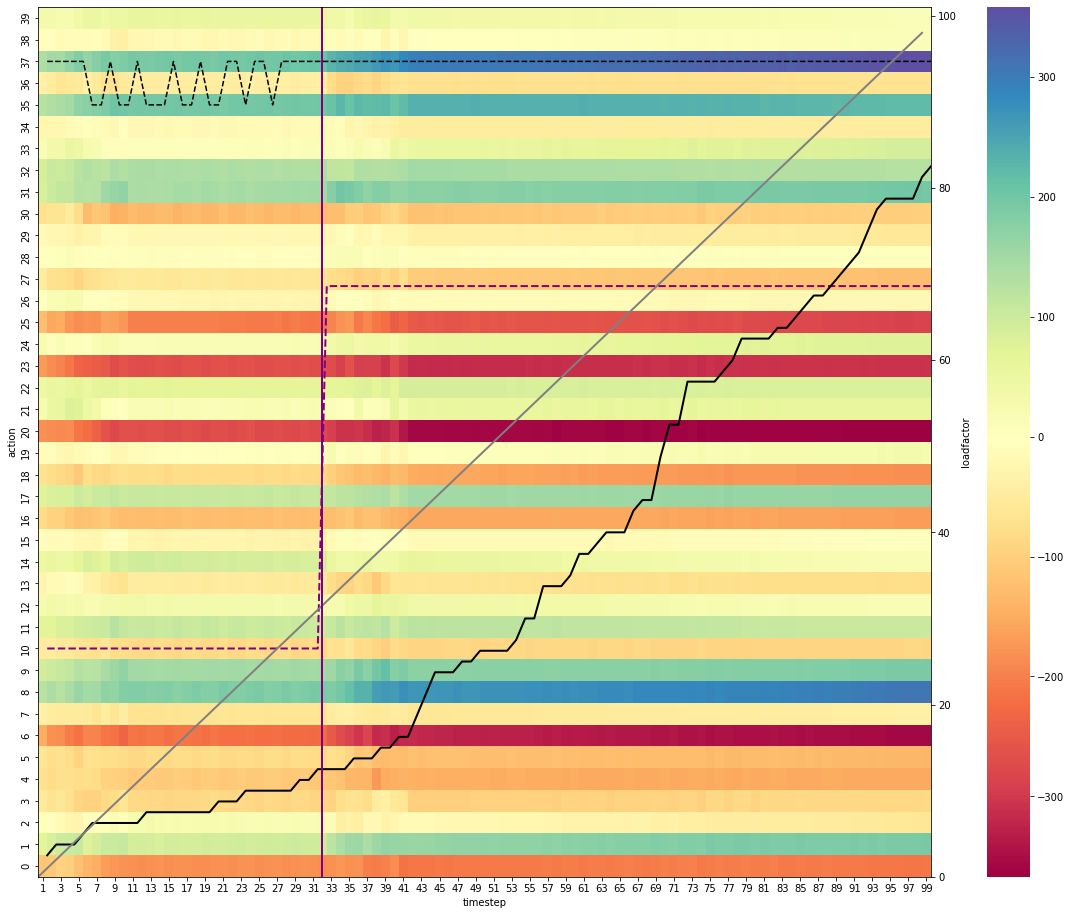

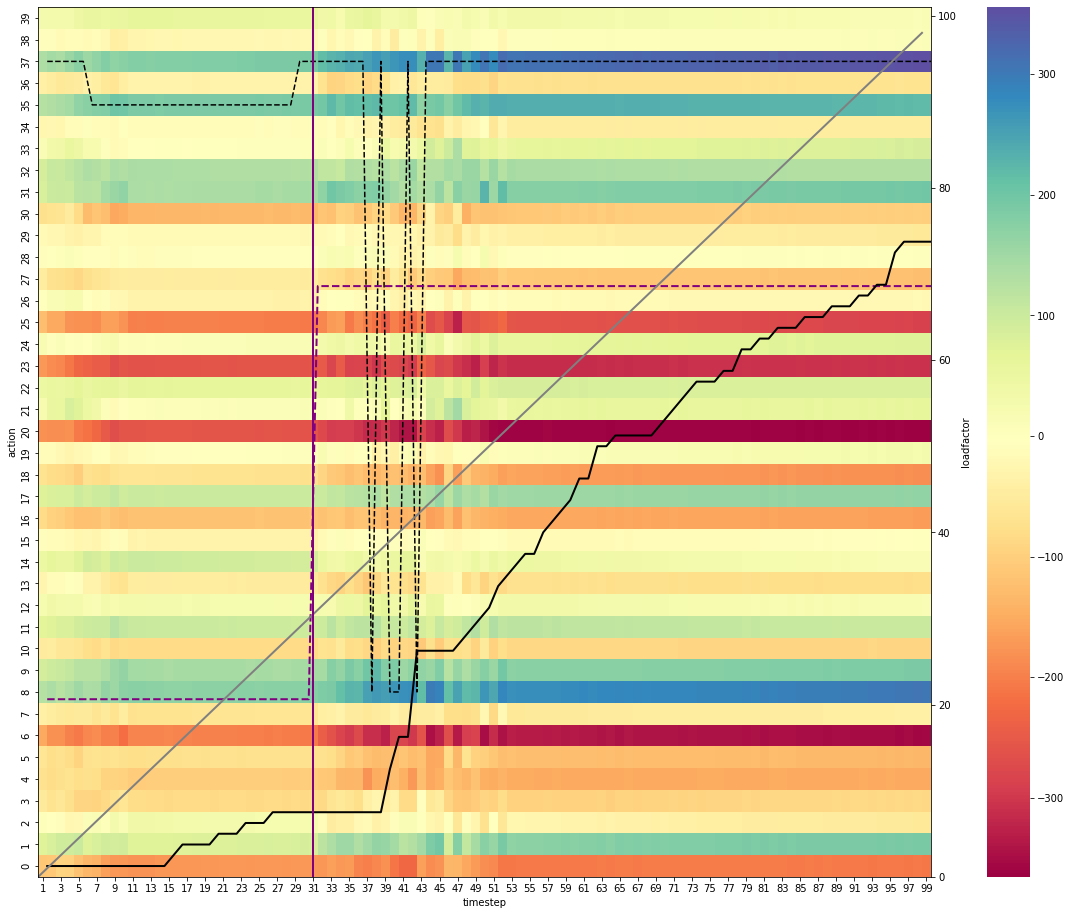

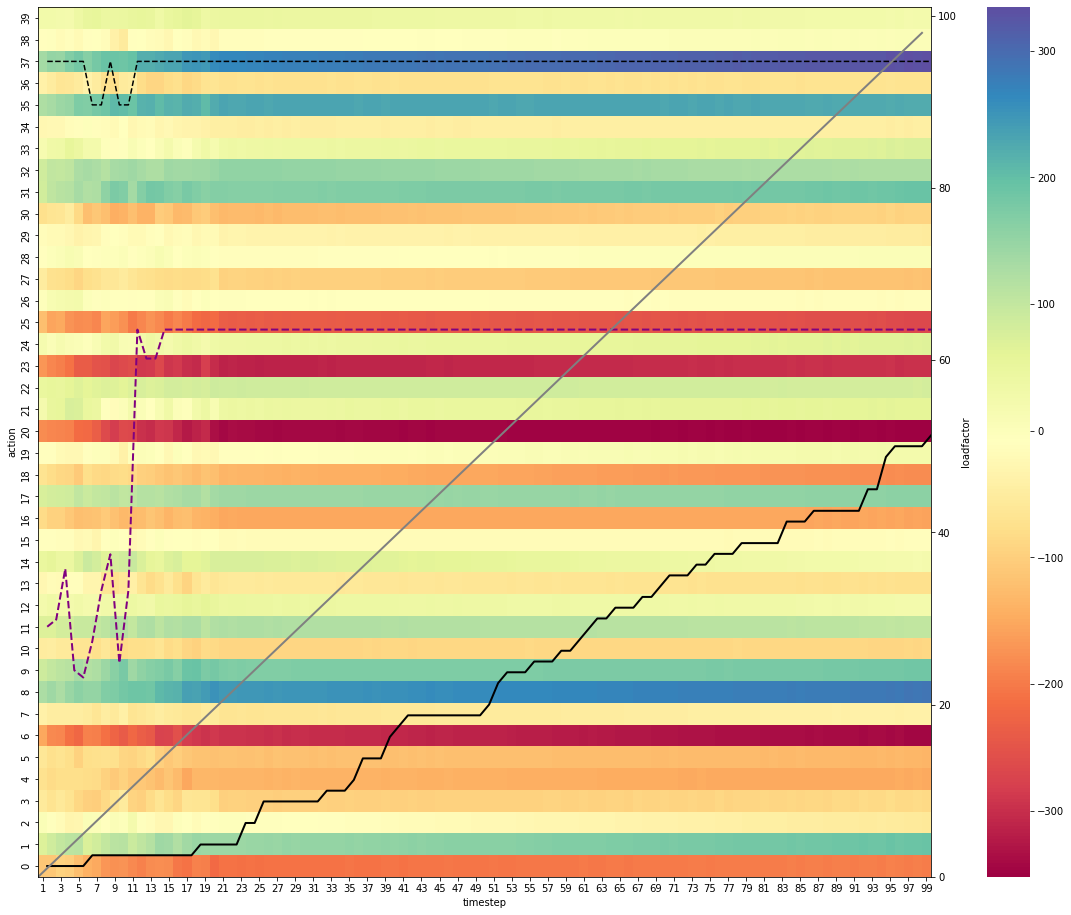

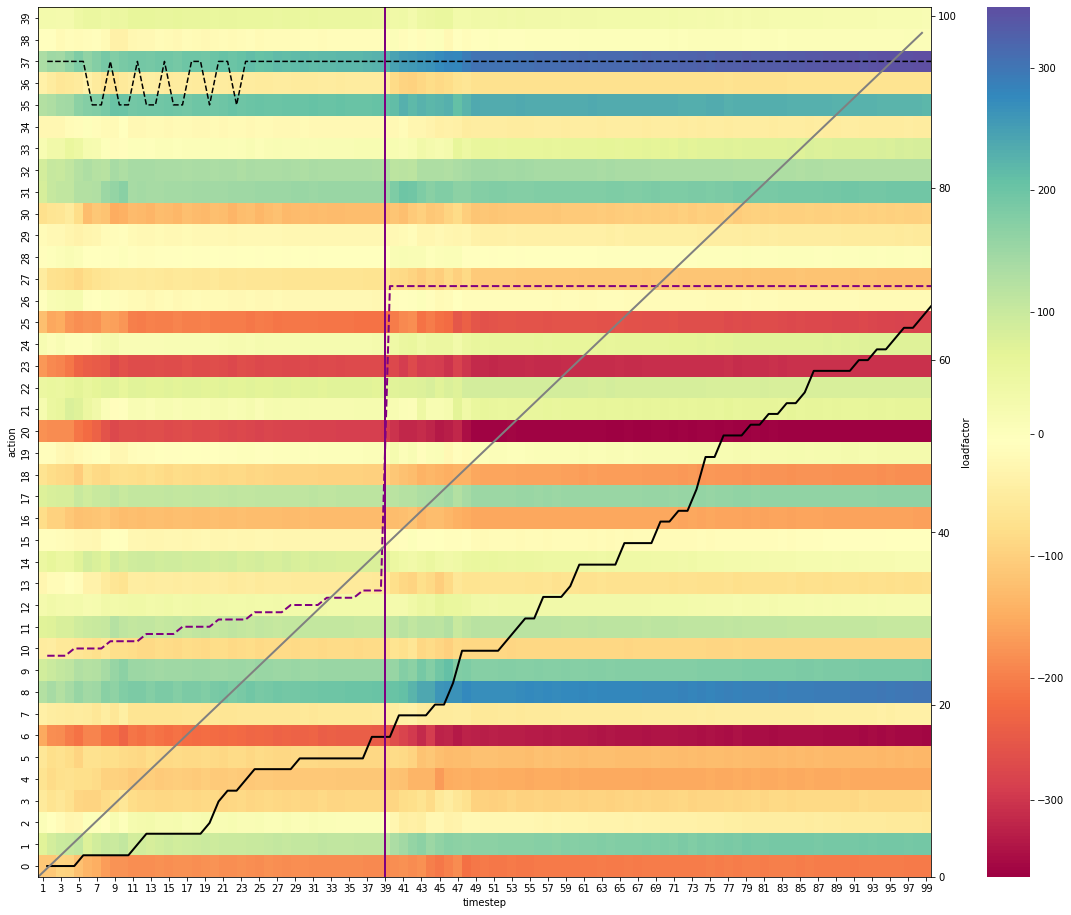

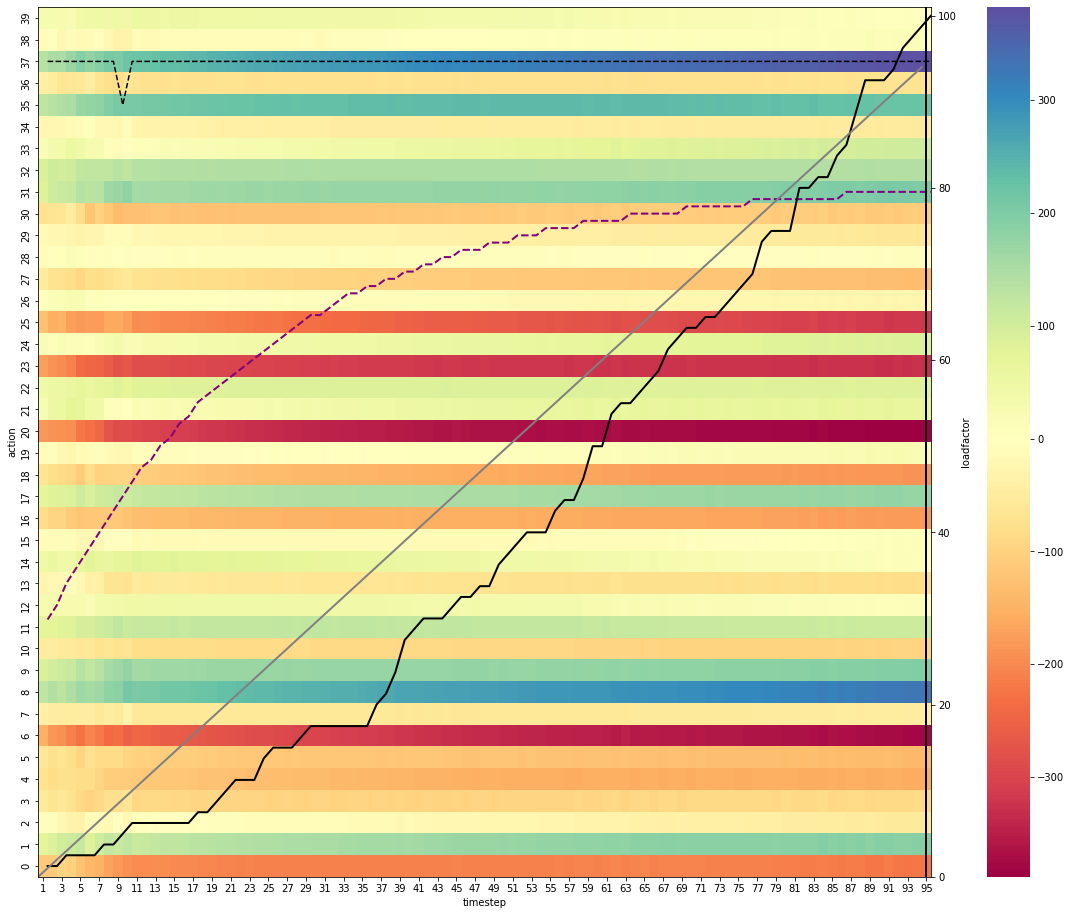

In [42]:
all_train_loss = []
all_metrics = []

run=None

# Plot for untrained model
for i in range(5):
    plot_qlogits_heatmap(qpolicy, eval_env,  dpc_game, 0, i, run)

In [44]:
train_agent(1000 * 100, agent.collect_policy, collect_driver)
train_checkpointer.save(train_step_counter)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))



Iteration: 0, loss:307.12
Train step counter: 1, epsilon: 100.000
AverageReturn: 0.0

Iteration: 1000, loss:123.30
Train step counter: 1001, epsilon: 99.901
AverageReturn: -10620.5185546875

Iteration: 2000, loss:171.74
Train step counter: 2001, epsilon: 99.802
AverageReturn: -13002.0703125

Iteration: 3000, loss:88.58
Train step counter: 3001, epsilon: 99.703
AverageReturn: -12434.115234375

Iteration: 4000, loss:196.42
Train step counter: 4001, epsilon: 99.604
AverageReturn: -9172.939453125

Iteration: 5000, loss:86.47
Train step counter: 5001, epsilon: 99.505
AverageReturn: -8735.4169921875

Iteration: 6000, loss:290.31
Train step counter: 6001, epsilon: 99.406
AverageReturn: -7675.62353515625

Iteration: 7000, loss:150.09
Train step counter: 7001, epsilon: 99.307
AverageReturn: -6554.32666015625

Iteration: 8000, loss:273.64
Train step counter: 8001, epsilon: 99.208
AverageReturn: -7059.2412109375

Iteration: 9000, loss:198.55
Train step counter: 9001, epsilon: 99.109
AverageRetur


Iteration: 78000, loss:166.25
Train step counter: 78001, epsilon: 92.278
AverageReturn: 1800.0081787109375

Iteration: 79000, loss:159.95
Train step counter: 79001, epsilon: 92.179
AverageReturn: 1782.871826171875

Iteration: 80000, loss:110.70
Train step counter: 80001, epsilon: 92.080
AverageReturn: 2252.891357421875

Iteration: 81000, loss:163.28
Train step counter: 81001, epsilon: 91.981
AverageReturn: 1439.113525390625

Iteration: 82000, loss:105.61
Train step counter: 82001, epsilon: 91.882
AverageReturn: 1240.9744873046875

Iteration: 83000, loss:170.99
Train step counter: 83001, epsilon: 91.783
AverageReturn: 1868.521484375

Iteration: 84000, loss:145.35
Train step counter: 84001, epsilon: 91.684
AverageReturn: 2053.12646484375

Iteration: 85000, loss:81.53
Train step counter: 85001, epsilon: 91.585
AverageReturn: 1538.0400390625

Iteration: 86000, loss:119.95
Train step counter: 86001, epsilon: 91.486
AverageReturn: 1335.8255615234375

Iteration: 87000, loss:208.81
Train step

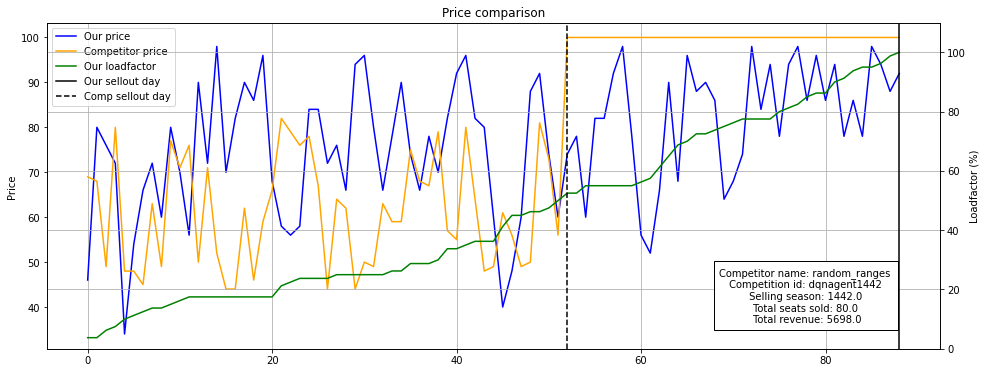

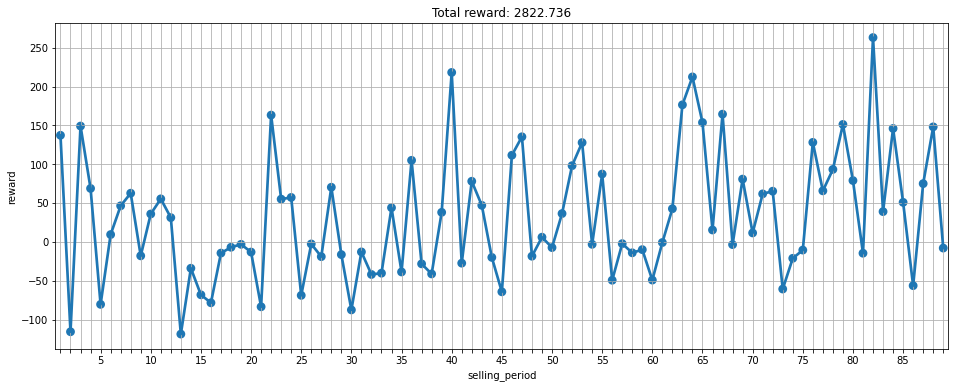

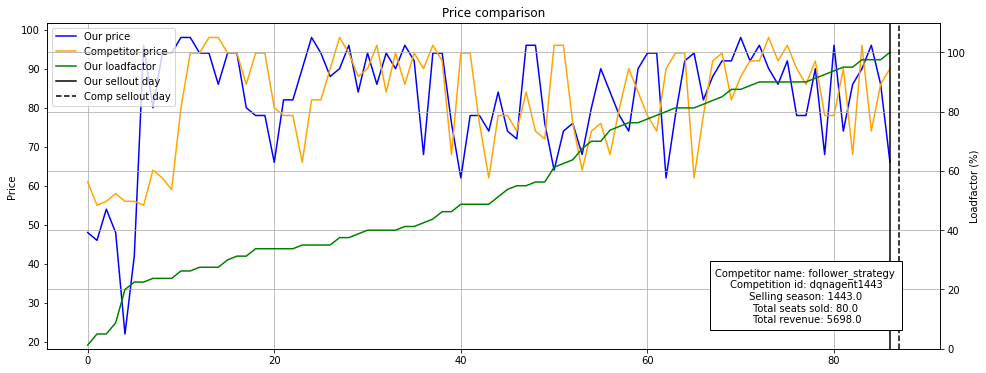

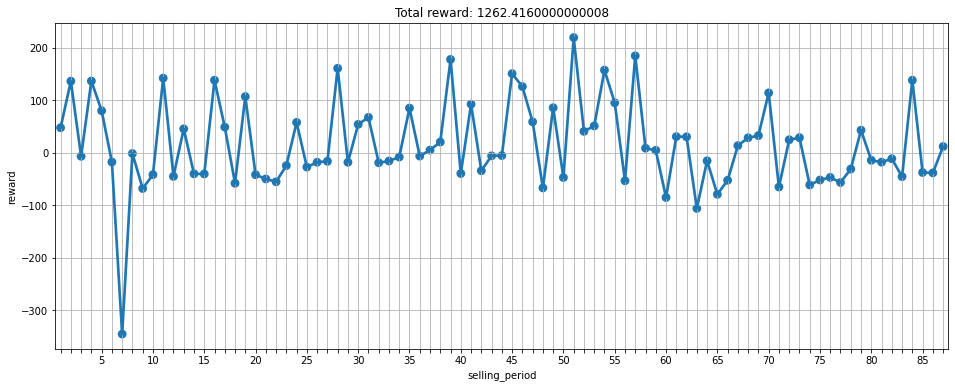

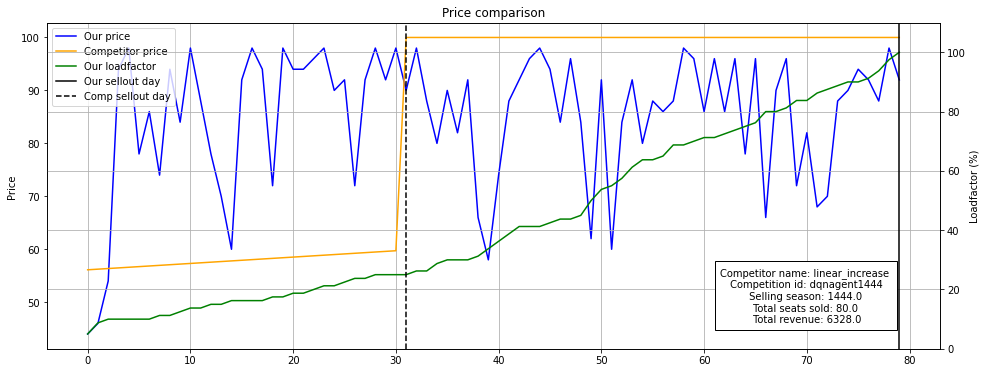

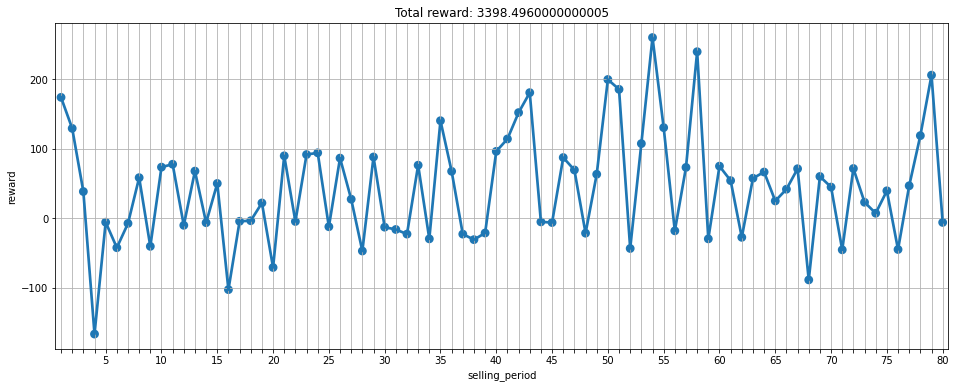

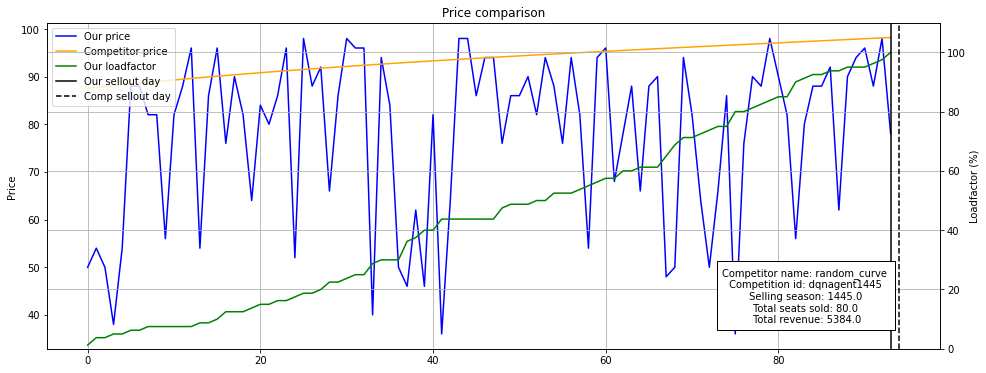

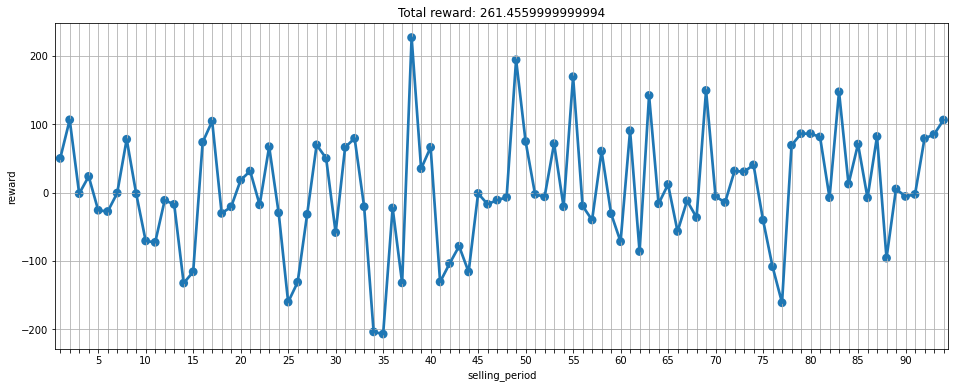

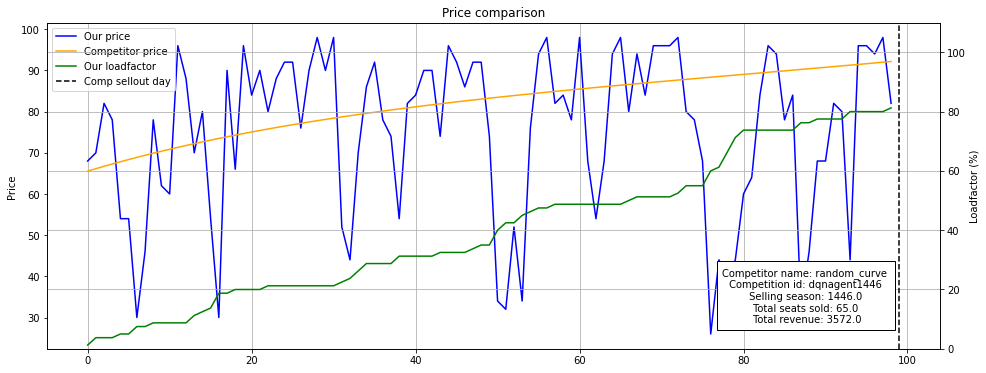

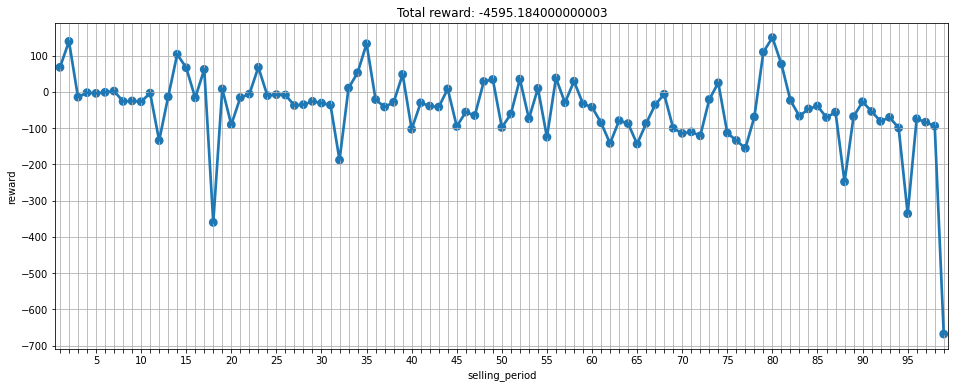

In [45]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'

    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, None)
    plot_reward_per_period(dpc_game.competition_results_df, competition_id, selling_season, None)

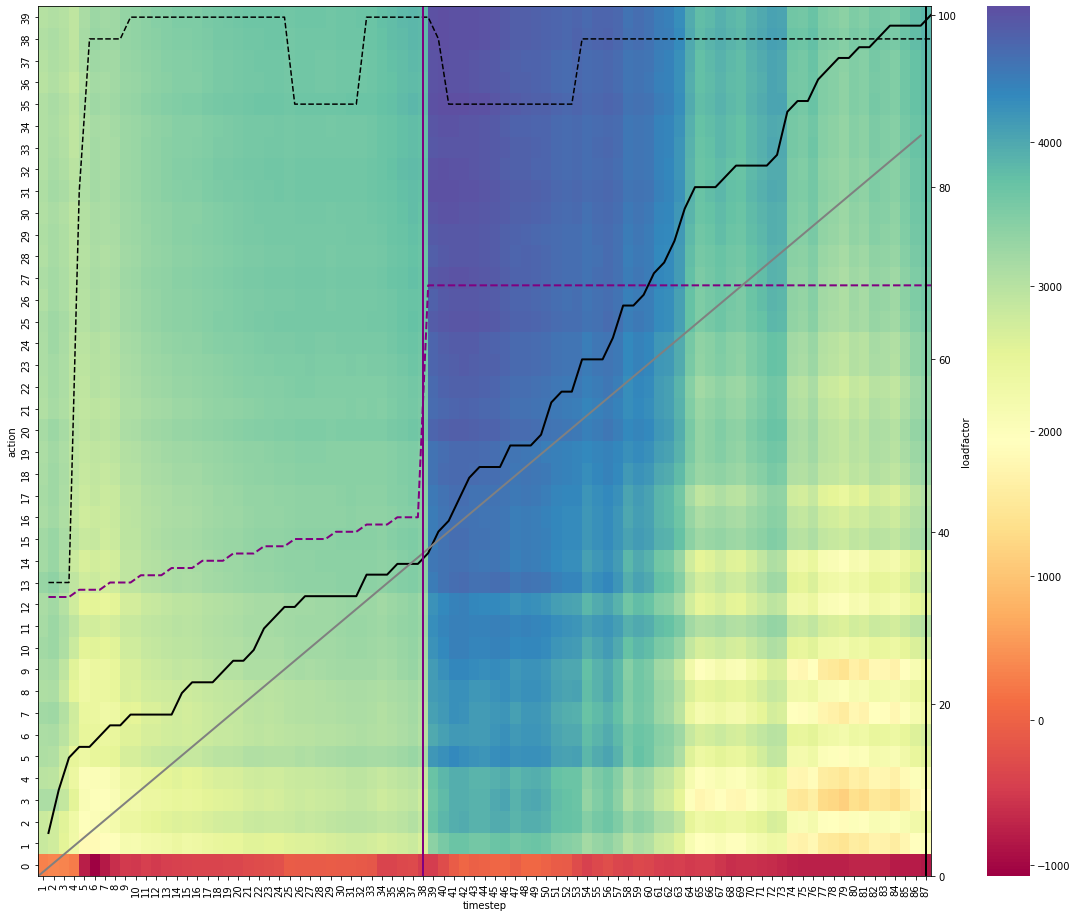

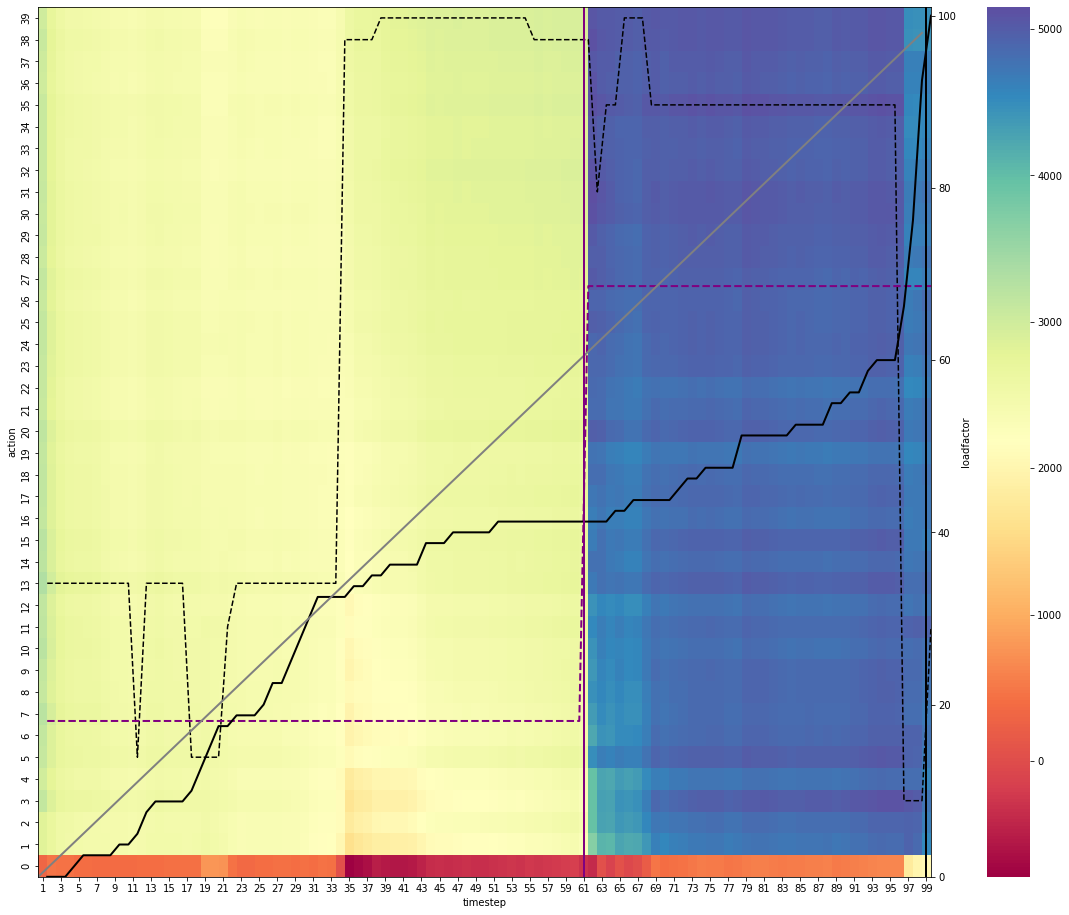

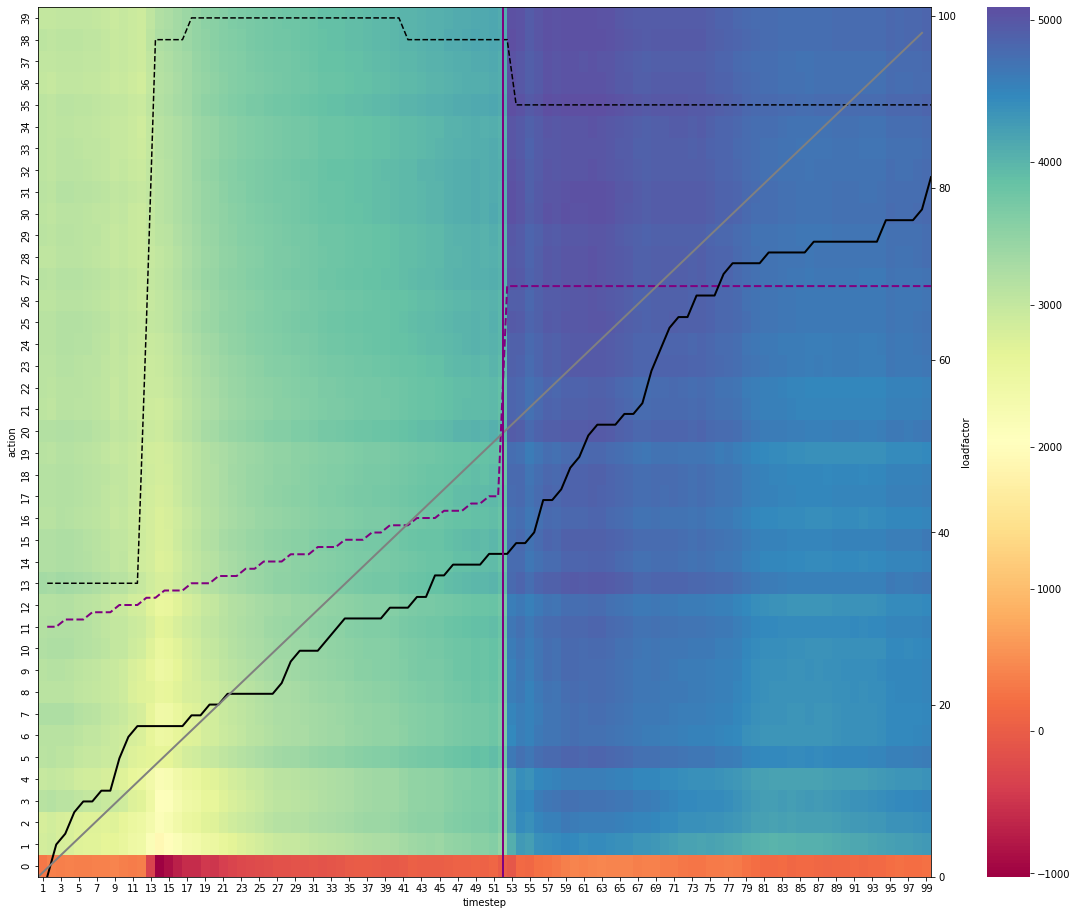

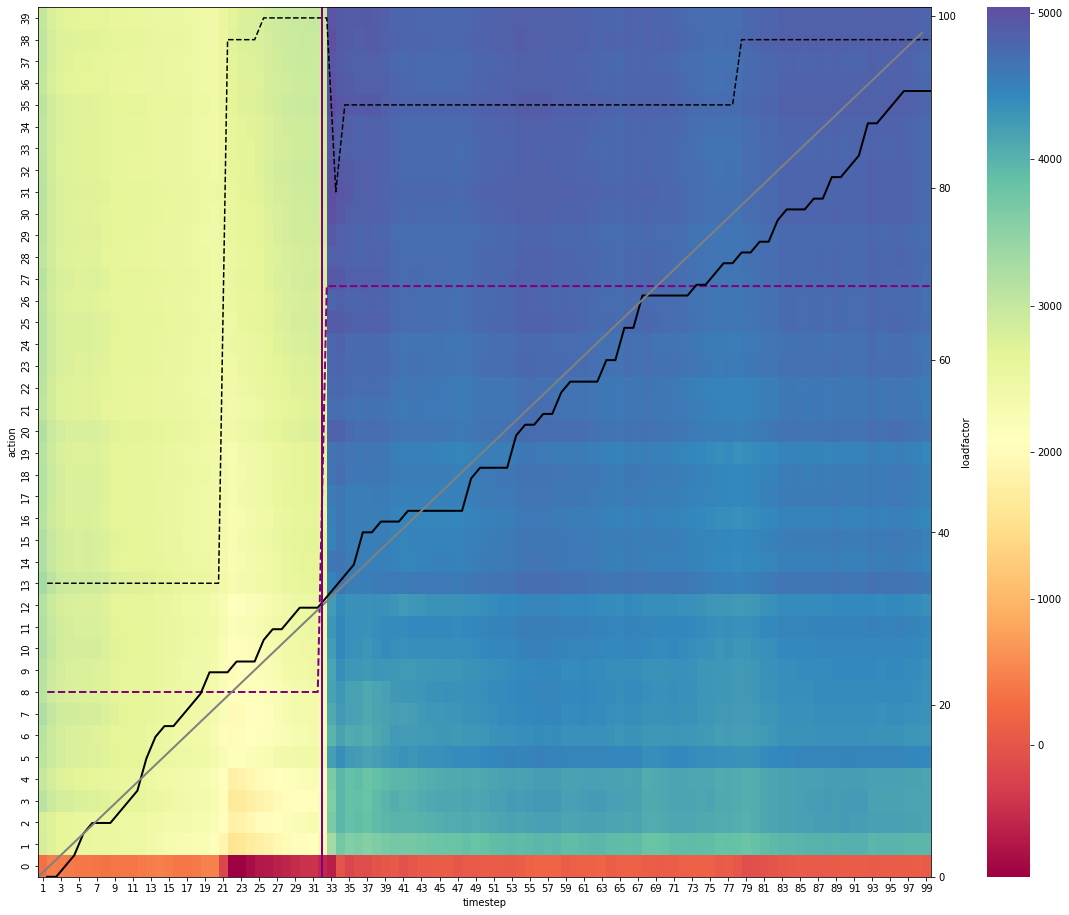

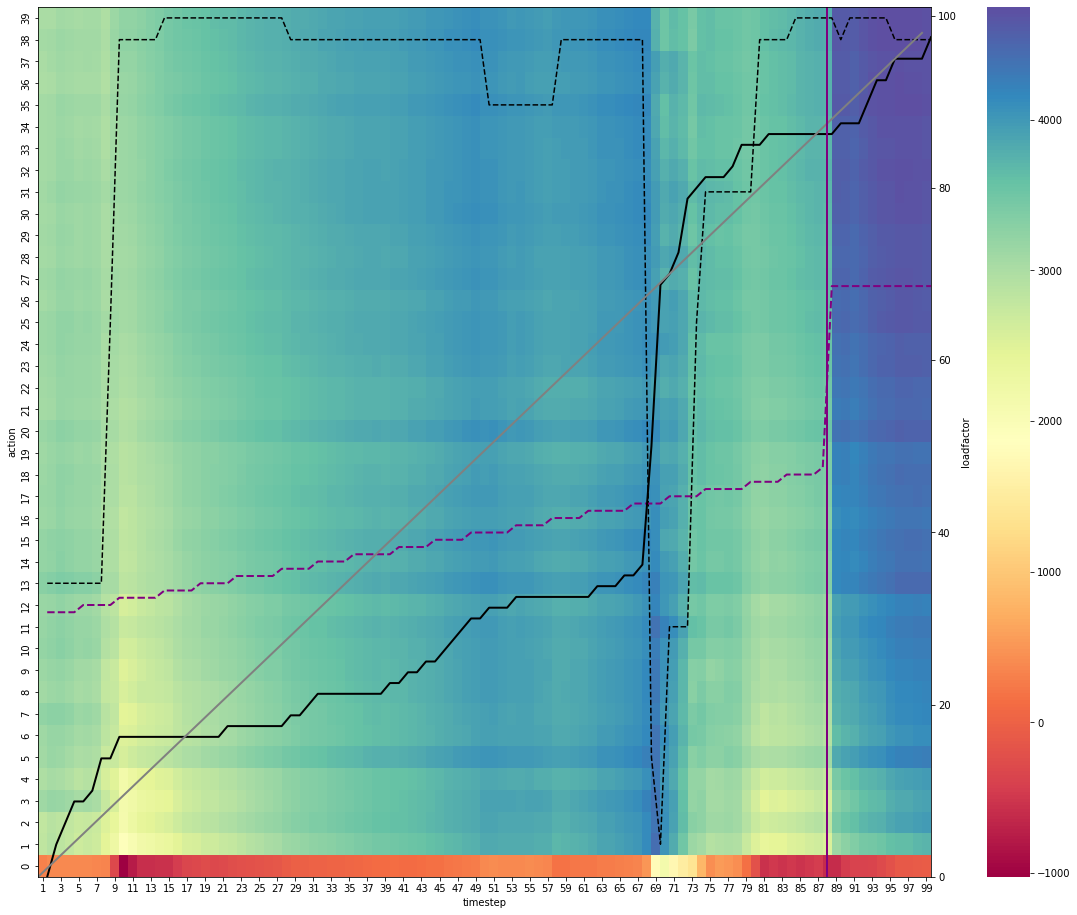

In [47]:
for i in range(5):
    plot_qlogits_heatmap(qpolicy, eval_env, dpc_game, i+1, i, None)

In [53]:
train_agent(2000 * 100, agent.collect_policy, collect_driver)
train_checkpointer.save(train_step_counter)


Iteration: 0, loss:131.53
Train step counter: 100001, epsilon: 90.100
AverageReturn: 1692.4879150390625

Iteration: 1000, loss:124.17
Train step counter: 101001, epsilon: 90.001
AverageReturn: 1004.7936401367188

Iteration: 2000, loss:145.47
Train step counter: 102001, epsilon: 89.902
AverageReturn: 1484.4063720703125

Iteration: 3000, loss:173.89
Train step counter: 103001, epsilon: 89.803
AverageReturn: 1136.3294677734375

Iteration: 4000, loss:186.76
Train step counter: 104001, epsilon: 89.704
AverageReturn: 2324.491455078125

Iteration: 5000, loss:103.07
Train step counter: 105001, epsilon: 89.605
AverageReturn: 1432.622314453125

Iteration: 6000, loss:110.20
Train step counter: 106001, epsilon: 89.506
AverageReturn: 1367.6558837890625

Iteration: 7000, loss:161.96
Train step counter: 107001, epsilon: 89.407
AverageReturn: 1299.7857666015625

Iteration: 8000, loss:186.60
Train step counter: 108001, epsilon: 89.308
AverageReturn: 788.031982421875

Iteration: 9000, loss:184.81
Train


Iteration: 77000, loss:183.34
Train step counter: 177001, epsilon: 82.477
AverageReturn: 1276.3262939453125

Iteration: 78000, loss:302.68
Train step counter: 178001, epsilon: 82.378
AverageReturn: 874.0958862304688

Iteration: 79000, loss:138.49
Train step counter: 179001, epsilon: 82.279
AverageReturn: 1313.4576416015625

Iteration: 80000, loss:172.50
Train step counter: 180001, epsilon: 82.180
AverageReturn: 1499.4078369140625

Iteration: 81000, loss:168.51
Train step counter: 181001, epsilon: 82.081
AverageReturn: 2497.433349609375

Iteration: 82000, loss:327.95
Train step counter: 182001, epsilon: 81.982
AverageReturn: 2423.76318359375

Iteration: 83000, loss:538.32
Train step counter: 183001, epsilon: 81.883
AverageReturn: 1233.760009765625

Iteration: 84000, loss:179.89
Train step counter: 184001, epsilon: 81.784
AverageReturn: 2386.35693359375

Iteration: 85000, loss:185.98
Train step counter: 185001, epsilon: 81.685
AverageReturn: 2193.672119140625

Iteration: 86000, loss:267


Iteration: 153000, loss:233.52
Train step counter: 253001, epsilon: 74.953
AverageReturn: 1728.135986328125

Iteration: 154000, loss:376.61
Train step counter: 254001, epsilon: 74.854
AverageReturn: 1988.3935546875

Iteration: 155000, loss:359.19
Train step counter: 255001, epsilon: 74.755
AverageReturn: 1432.278076171875

Iteration: 156000, loss:143.52
Train step counter: 256001, epsilon: 74.656
AverageReturn: 1891.353759765625

Iteration: 157000, loss:385.98
Train step counter: 257001, epsilon: 74.557
AverageReturn: 1249.3280029296875

Iteration: 158000, loss:214.61
Train step counter: 258001, epsilon: 74.458
AverageReturn: 1966.9521484375

Iteration: 159000, loss:164.35
Train step counter: 259001, epsilon: 74.359
AverageReturn: 2453.35205078125

Iteration: 160000, loss:246.66
Train step counter: 260001, epsilon: 74.260
AverageReturn: 1919.087890625

Iteration: 161000, loss:476.07
Train step counter: 261001, epsilon: 74.161
AverageReturn: 1547.05126953125

Iteration: 162000, loss:20

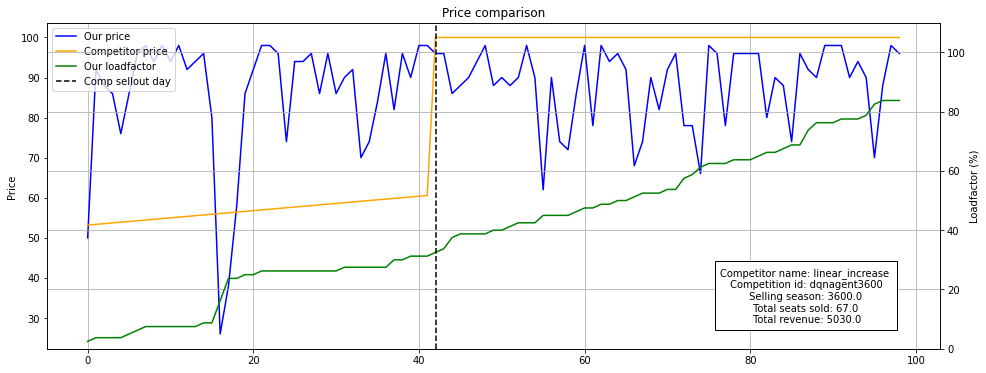

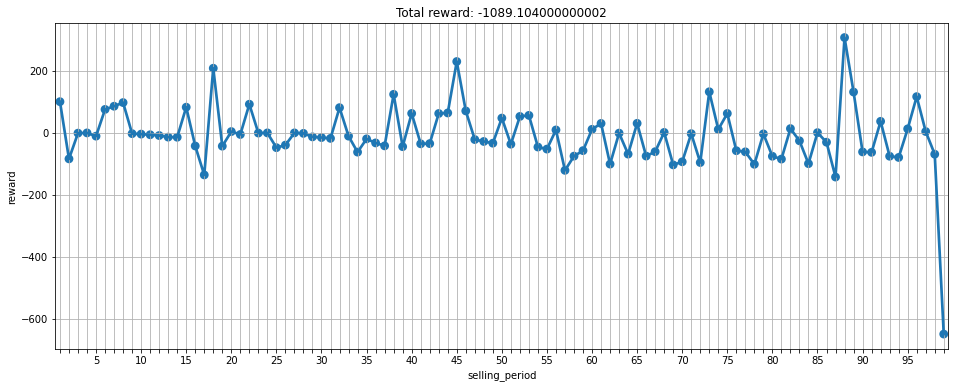

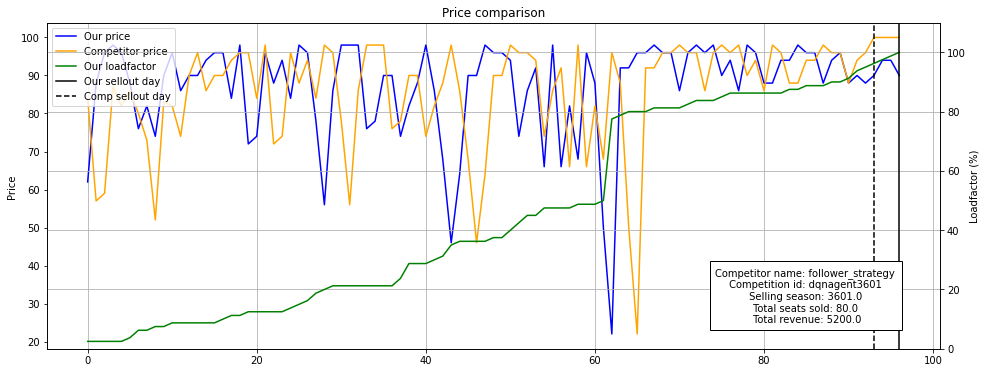

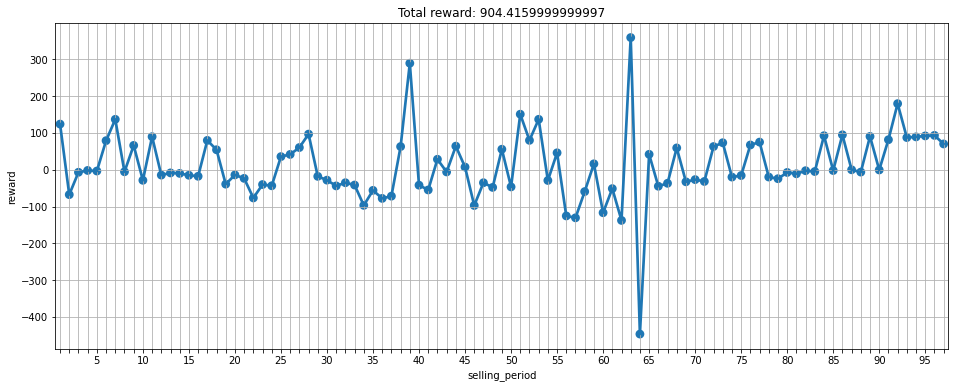

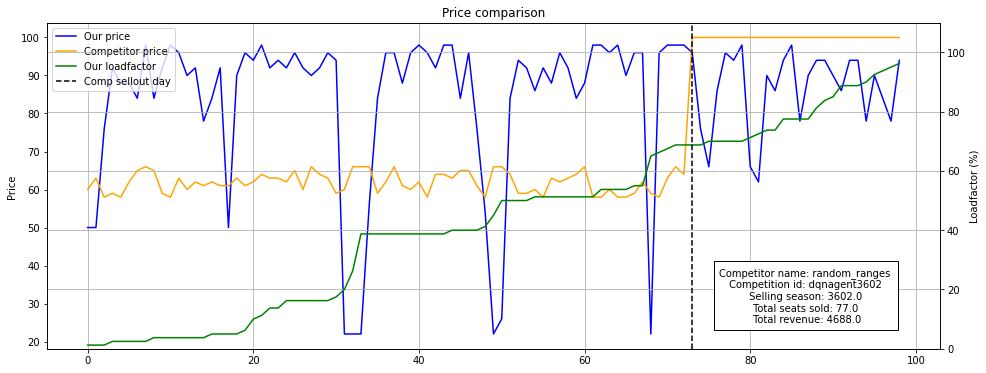

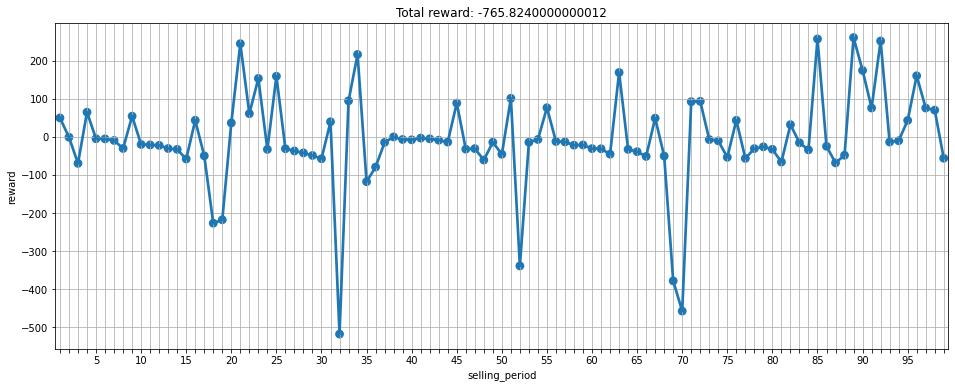

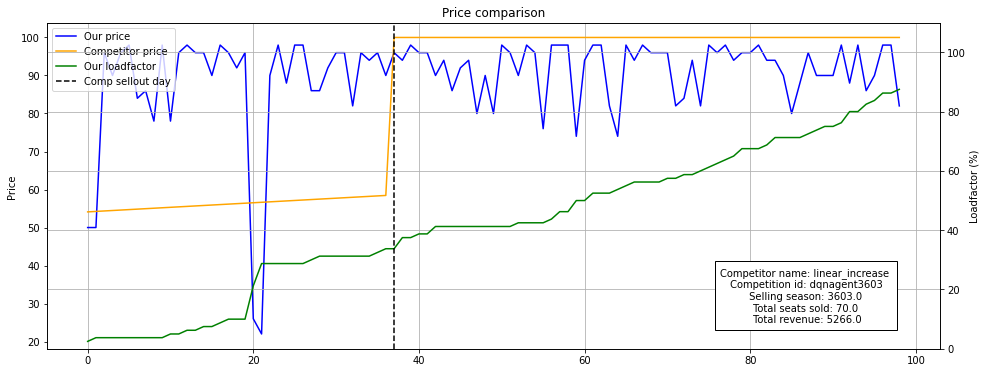

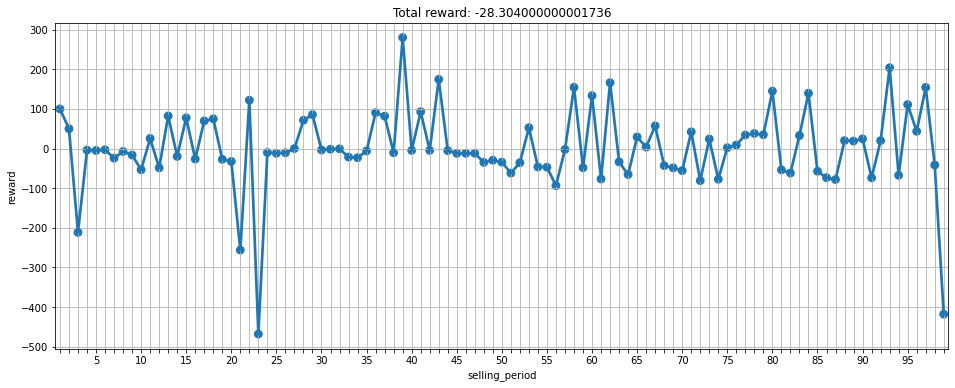

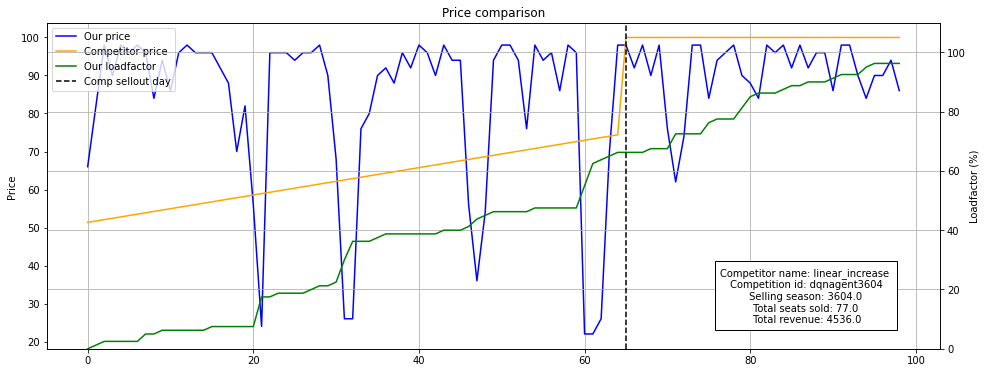

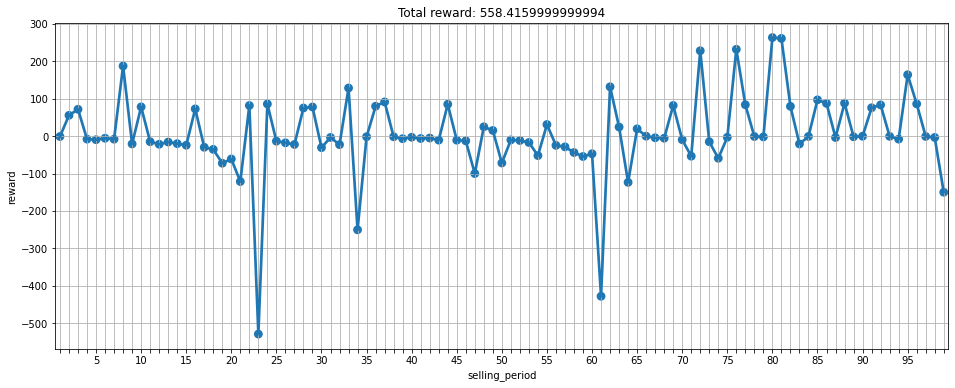

In [54]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'

    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, None)
    plot_reward_per_period(dpc_game.competition_results_df, competition_id, selling_season, None)

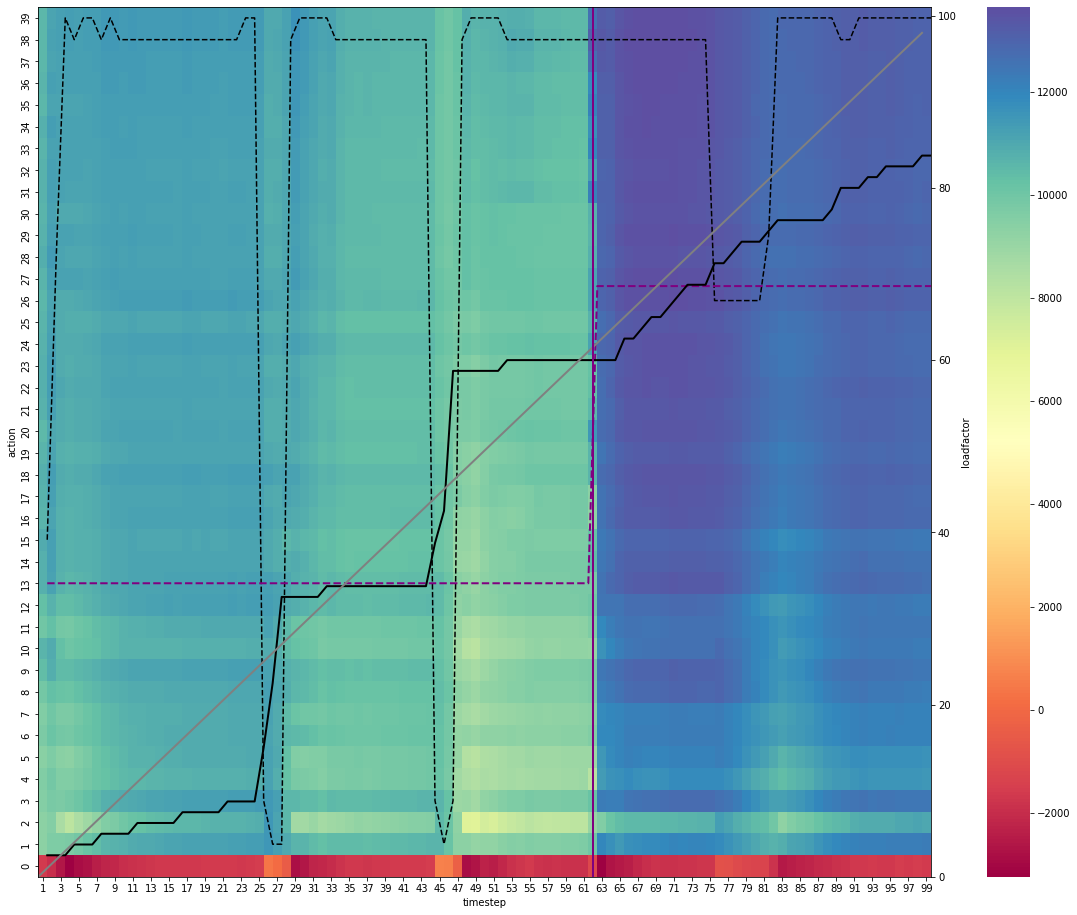

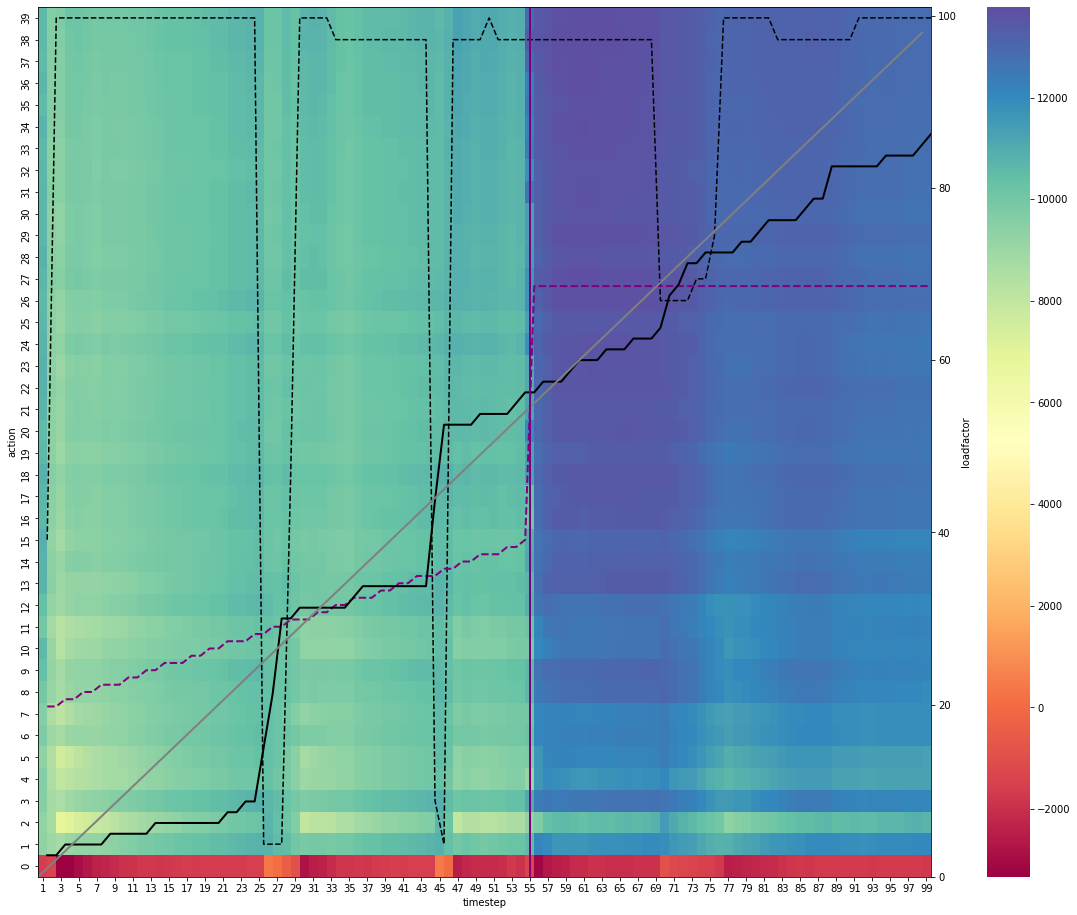

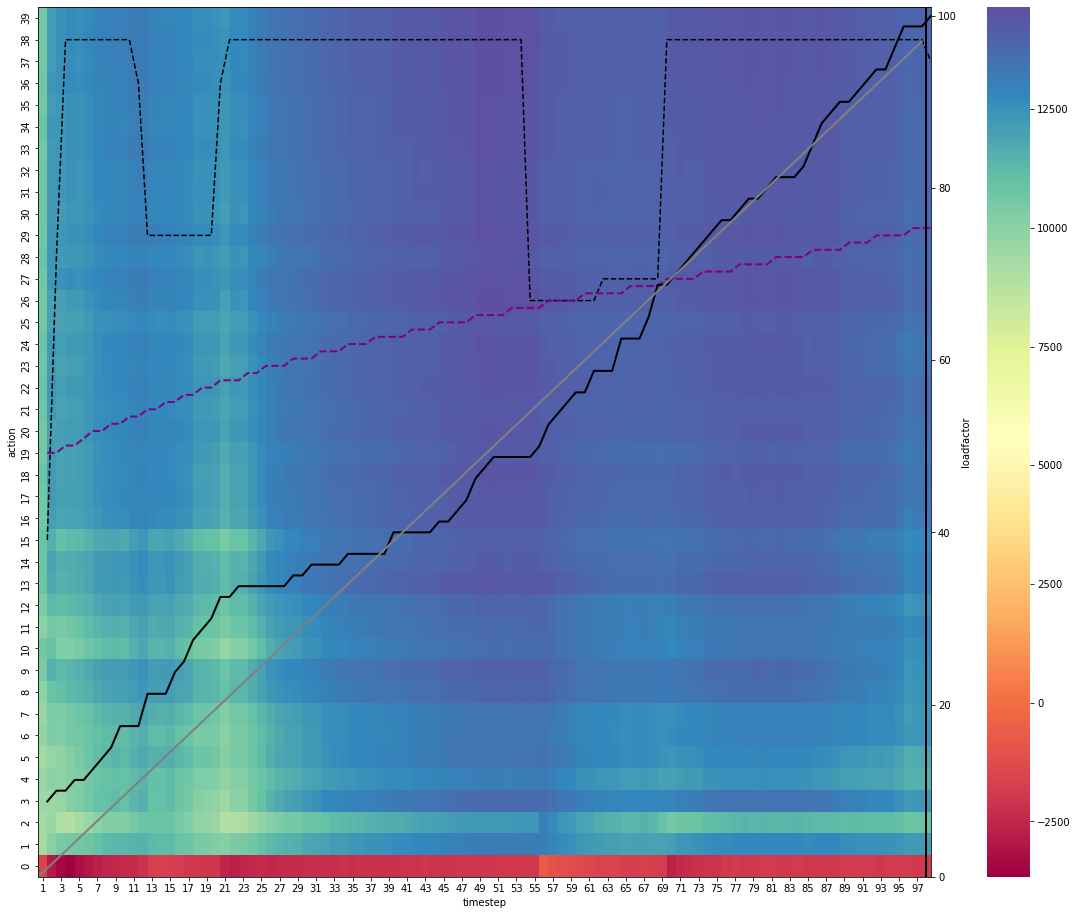

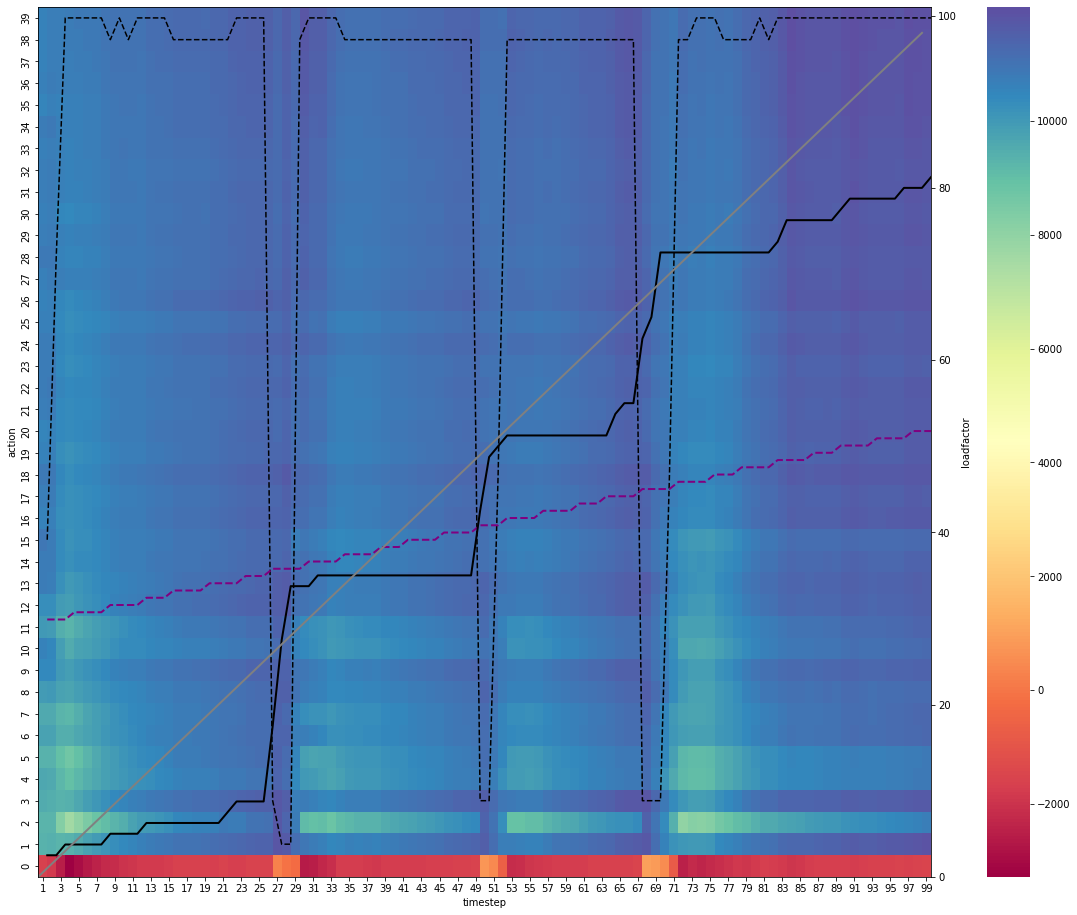

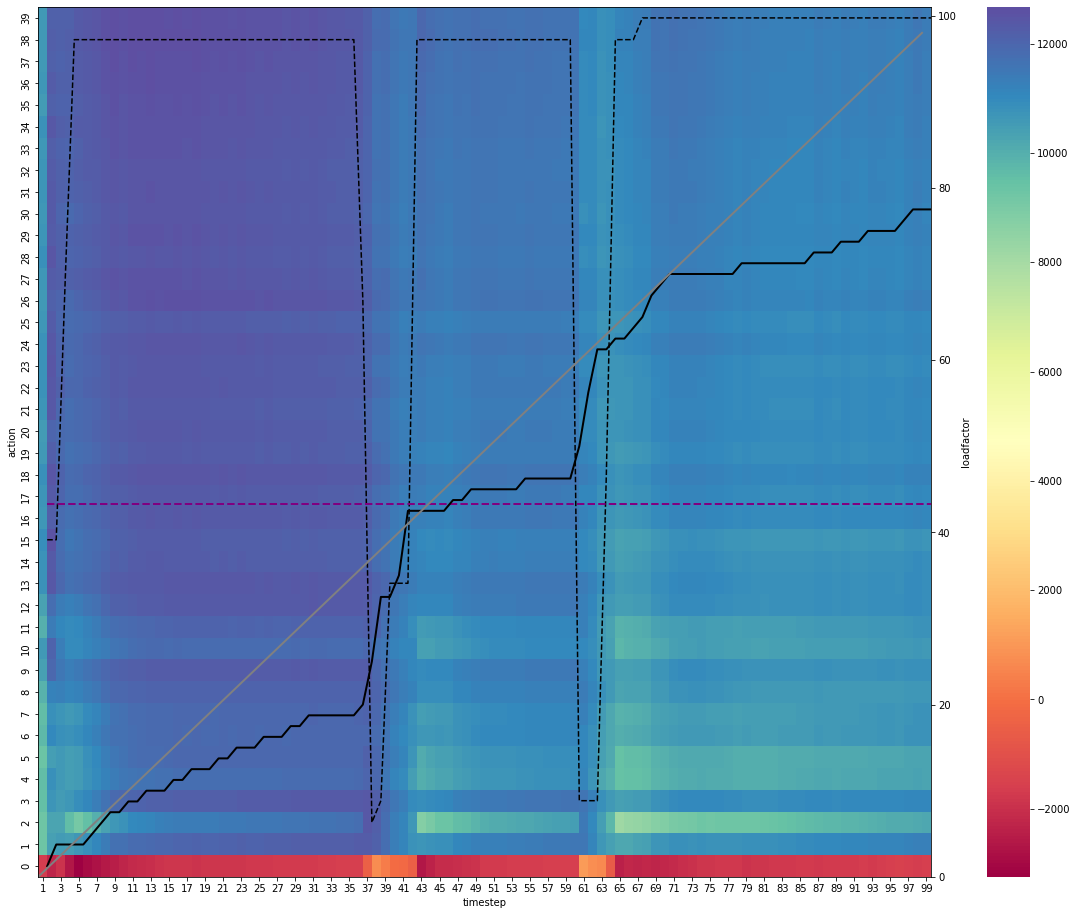

In [55]:
for i in range(5):
    plot_qlogits_heatmap(qpolicy, eval_env, dpc_game, i+1, i, None)

In [60]:
train_agent(3000 * 100, agent.collect_policy, collect_driver)
train_checkpointer.save(train_step_counter)


Iteration: 0, loss:484.40
Train step counter: 300001, epsilon: 70.300
AverageReturn: 118.5504150390625

Iteration: 1000, loss:333.71
Train step counter: 301001, epsilon: 70.201
AverageReturn: 682.10400390625

Iteration: 2000, loss:238.45
Train step counter: 302001, epsilon: 70.102
AverageReturn: 1374.737548828125

Iteration: 3000, loss:203.40
Train step counter: 303001, epsilon: 70.003
AverageReturn: 1803.089599609375

Iteration: 4000, loss:213.23
Train step counter: 304001, epsilon: 69.904
AverageReturn: -317.41766357421875

Iteration: 5000, loss:359.02
Train step counter: 305001, epsilon: 69.805
AverageReturn: 990.6705932617188

Iteration: 6000, loss:303.55
Train step counter: 306001, epsilon: 69.706
AverageReturn: -495.2159729003906

Iteration: 7000, loss:260.45
Train step counter: 307001, epsilon: 69.607
AverageReturn: 1888.183837890625

Iteration: 8000, loss:143.95
Train step counter: 308001, epsilon: 69.508
AverageReturn: 1722.9984130859375

Iteration: 9000, loss:124.80
Train st


Iteration: 77000, loss:287.51
Train step counter: 377001, epsilon: 62.677
AverageReturn: 139.86398315429688

Iteration: 78000, loss:312.86
Train step counter: 378001, epsilon: 62.578
AverageReturn: 1704.358642578125

Iteration: 79000, loss:203.01
Train step counter: 379001, epsilon: 62.479
AverageReturn: 549.3585205078125

Iteration: 80000, loss:238.09
Train step counter: 380001, epsilon: 62.380
AverageReturn: 913.283203125

Iteration: 81000, loss:333.78
Train step counter: 381001, epsilon: 62.281
AverageReturn: 2591.48486328125

Iteration: 82000, loss:282.12
Train step counter: 382001, epsilon: 62.182
AverageReturn: 2603.251220703125

Iteration: 83000, loss:505.14
Train step counter: 383001, epsilon: 62.083
AverageReturn: 2387.3564453125

Iteration: 84000, loss:734.43
Train step counter: 384001, epsilon: 61.984
AverageReturn: 208.72964477539062

Iteration: 85000, loss:491.94
Train step counter: 385001, epsilon: 61.885
AverageReturn: 1689.010986328125

Iteration: 86000, loss:251.22
Tr


Iteration: 153000, loss:353.65
Train step counter: 453001, epsilon: 55.153
AverageReturn: 2375.61279296875

Iteration: 154000, loss:971.33
Train step counter: 454001, epsilon: 55.054
AverageReturn: -1115.662841796875

Iteration: 155000, loss:816.66
Train step counter: 455001, epsilon: 54.955
AverageReturn: 1359.380615234375

Iteration: 156000, loss:685.16
Train step counter: 456001, epsilon: 54.856
AverageReturn: 1795.3072509765625

Iteration: 157000, loss:233.78
Train step counter: 457001, epsilon: 54.757
AverageReturn: 2666.433349609375

Iteration: 158000, loss:430.79
Train step counter: 458001, epsilon: 54.658
AverageReturn: 989.76171875

Iteration: 159000, loss:762.90
Train step counter: 459001, epsilon: 54.559
AverageReturn: 1381.4573974609375

Iteration: 160000, loss:436.65
Train step counter: 460001, epsilon: 54.460
AverageReturn: 1396.2130126953125

Iteration: 161000, loss:631.08
Train step counter: 461001, epsilon: 54.361
AverageReturn: 2218.98095703125

Iteration: 162000, lo


Iteration: 229000, loss:668.03
Train step counter: 529001, epsilon: 47.629
AverageReturn: 1477.76953125

Iteration: 230000, loss:576.49
Train step counter: 530001, epsilon: 47.530
AverageReturn: 2853.04150390625

Iteration: 231000, loss:314.60
Train step counter: 531001, epsilon: 47.431
AverageReturn: 2175.32666015625

Iteration: 232000, loss:295.00
Train step counter: 532001, epsilon: 47.332
AverageReturn: 54.068946838378906

Iteration: 233000, loss:315.44
Train step counter: 533001, epsilon: 47.233
AverageReturn: 2253.5390625

Iteration: 234000, loss:276.61
Train step counter: 534001, epsilon: 47.134
AverageReturn: 1160.729248046875

Iteration: 235000, loss:531.01
Train step counter: 535001, epsilon: 47.035
AverageReturn: 1098.716796875

Iteration: 236000, loss:284.37
Train step counter: 536001, epsilon: 46.936
AverageReturn: 2419.817626953125

Iteration: 237000, loss:582.30
Train step counter: 537001, epsilon: 46.837
AverageReturn: 2089.718505859375

Iteration: 238000, loss:416.66


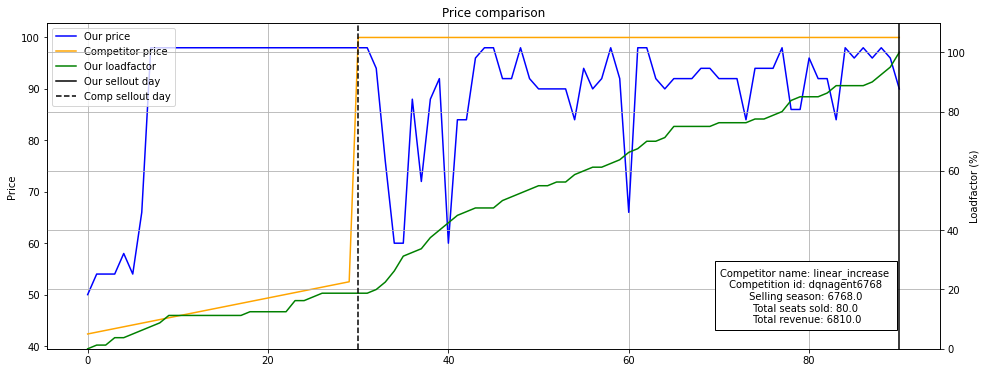

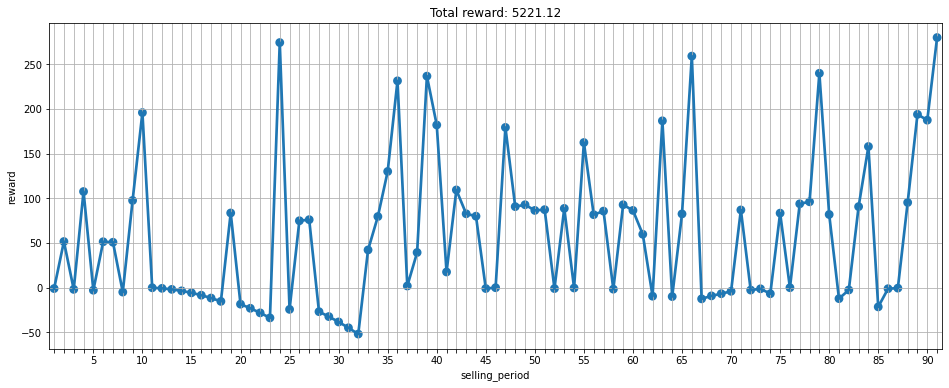

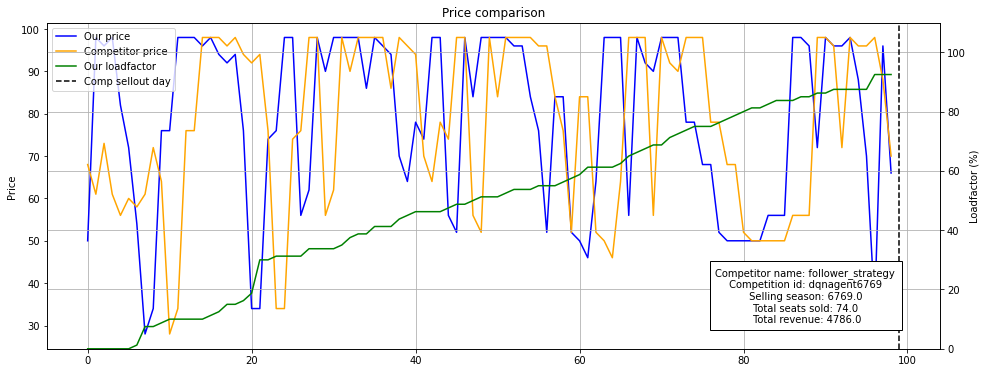

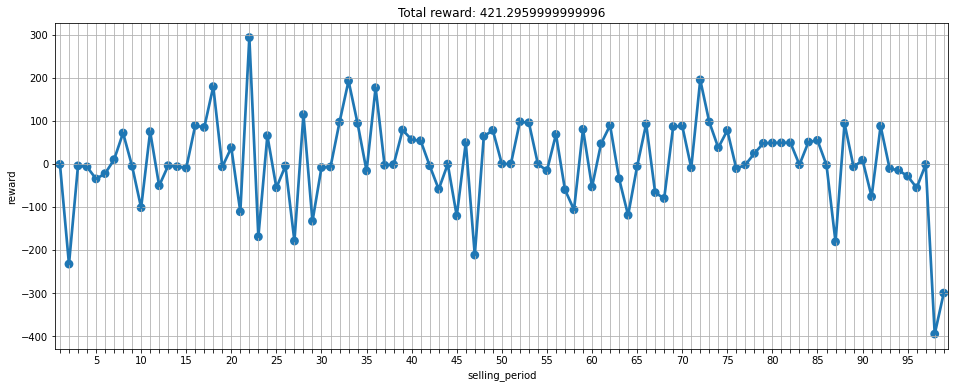

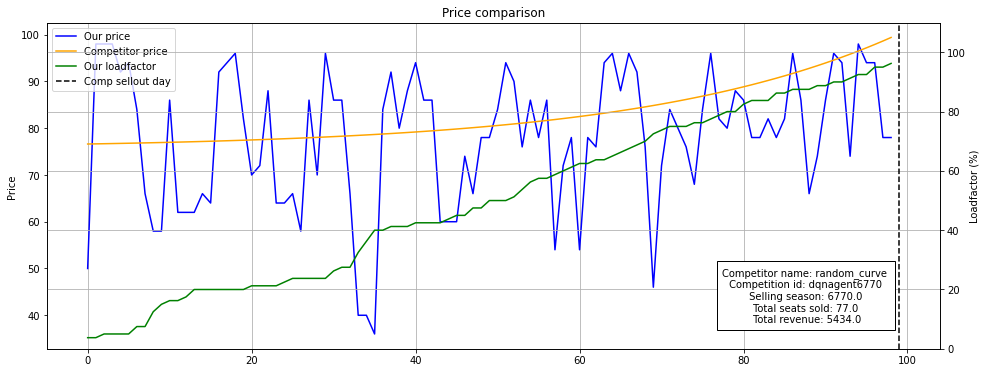

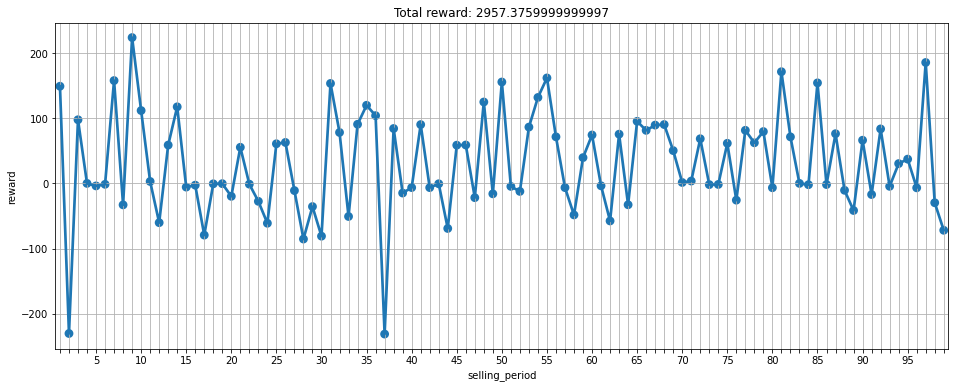

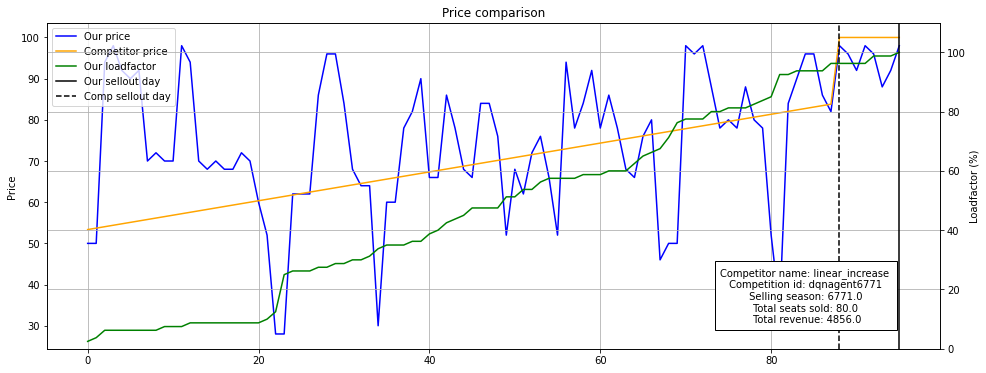

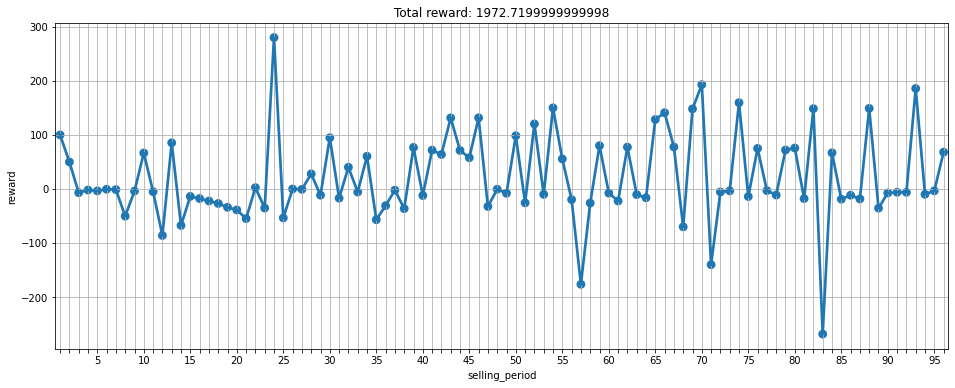

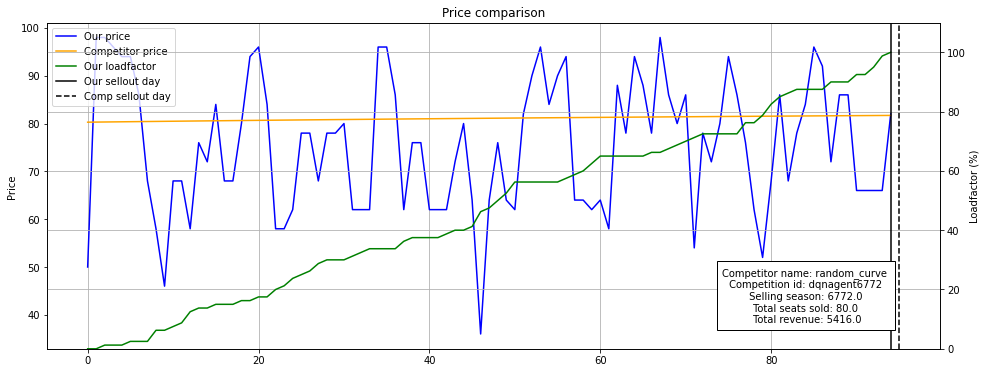

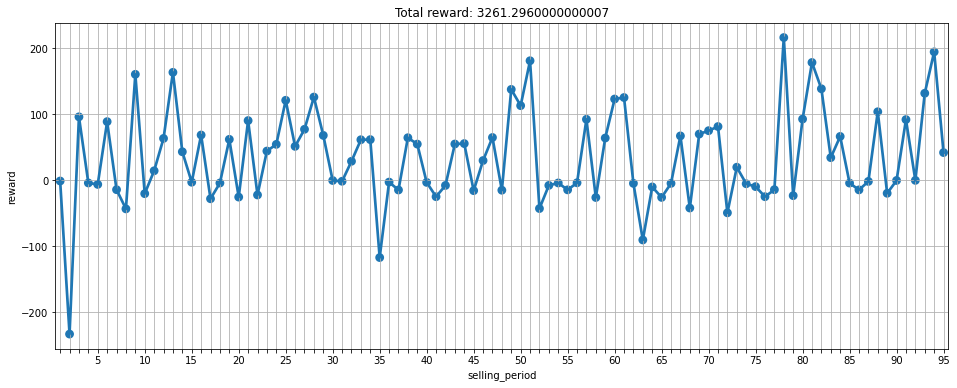

In [61]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'

    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, None)
    plot_reward_per_period(dpc_game.competition_results_df, competition_id, selling_season, None)

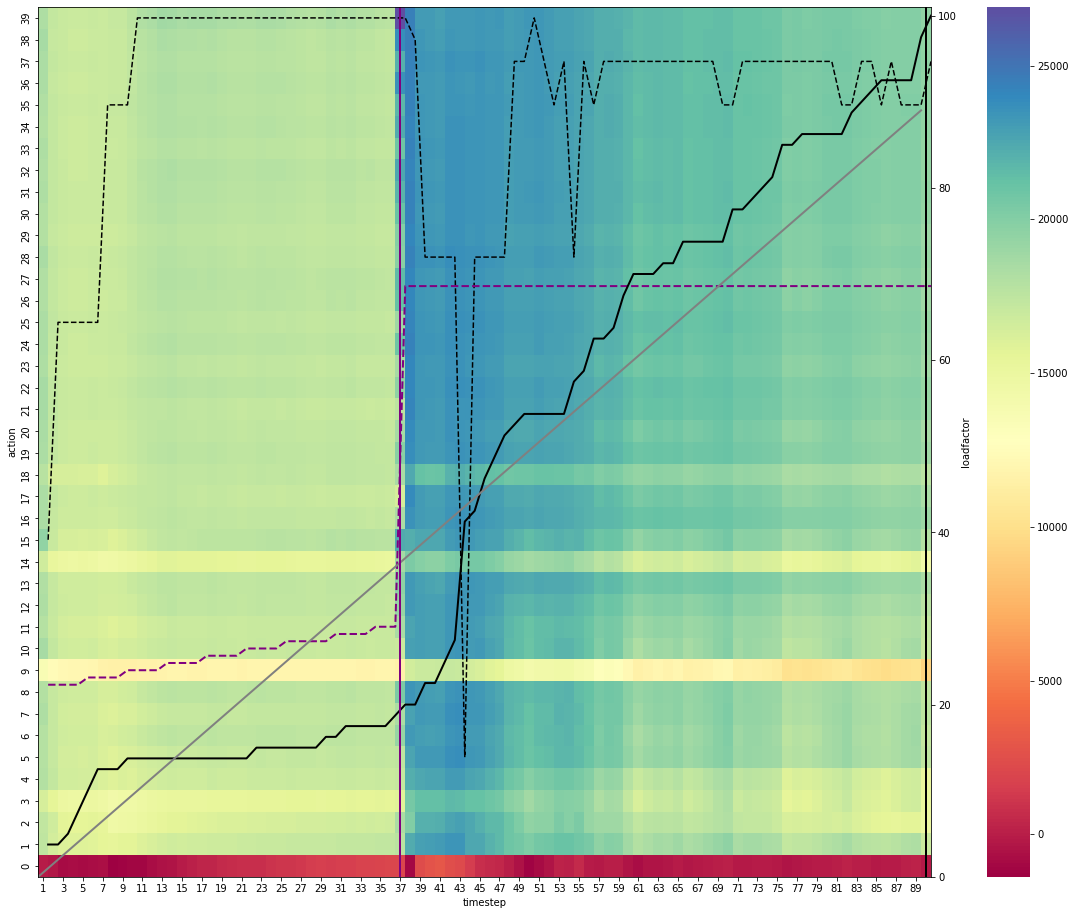

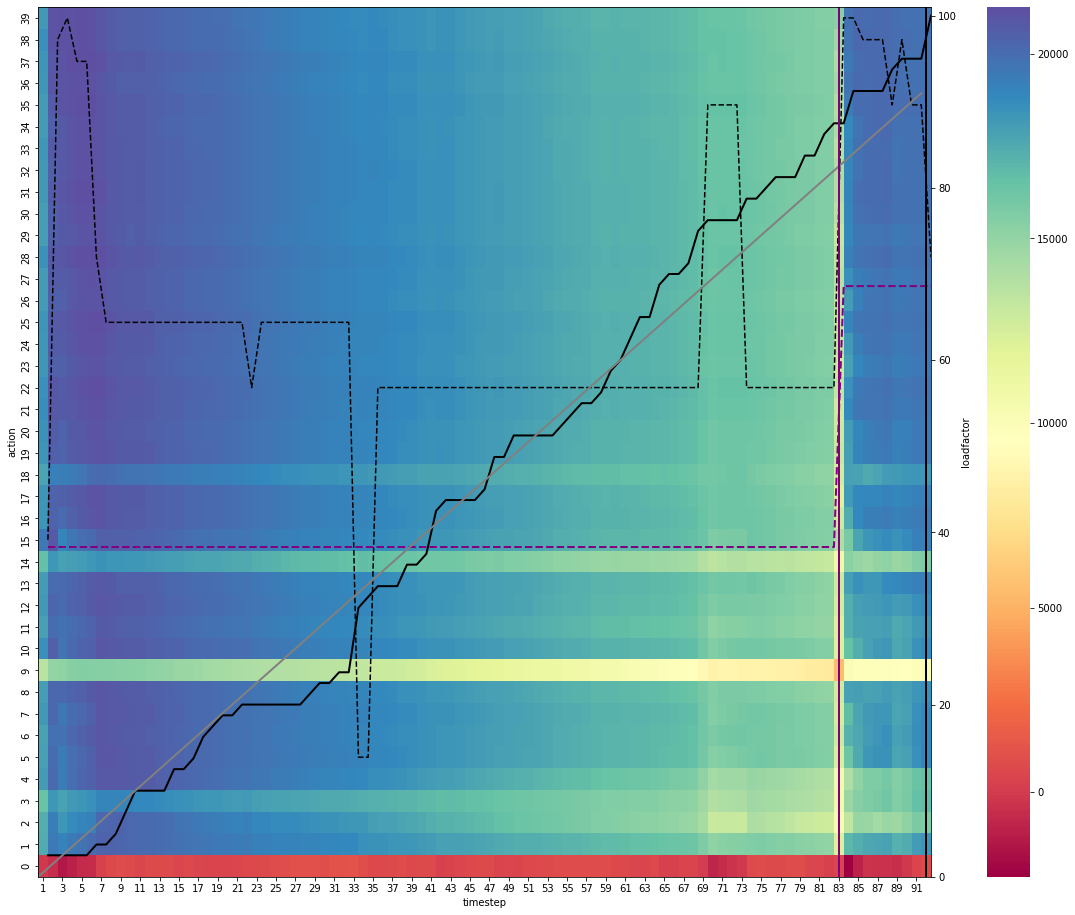

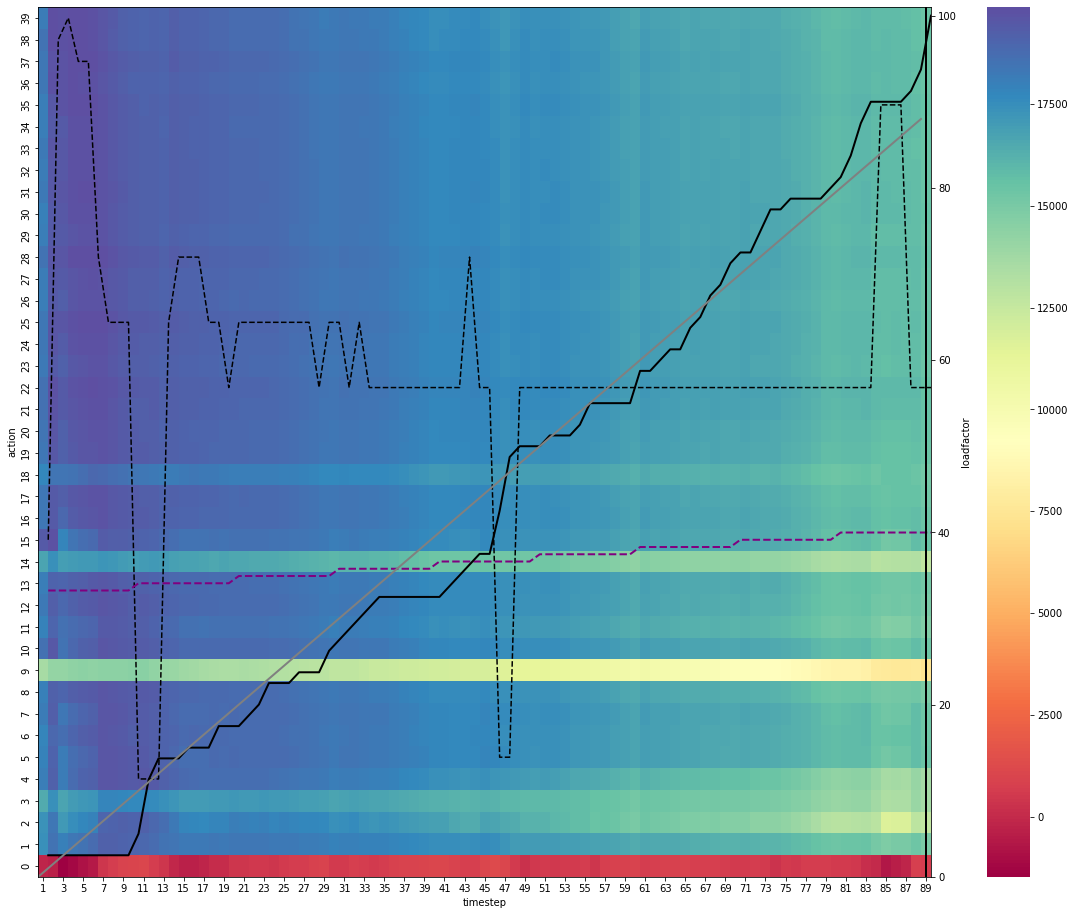

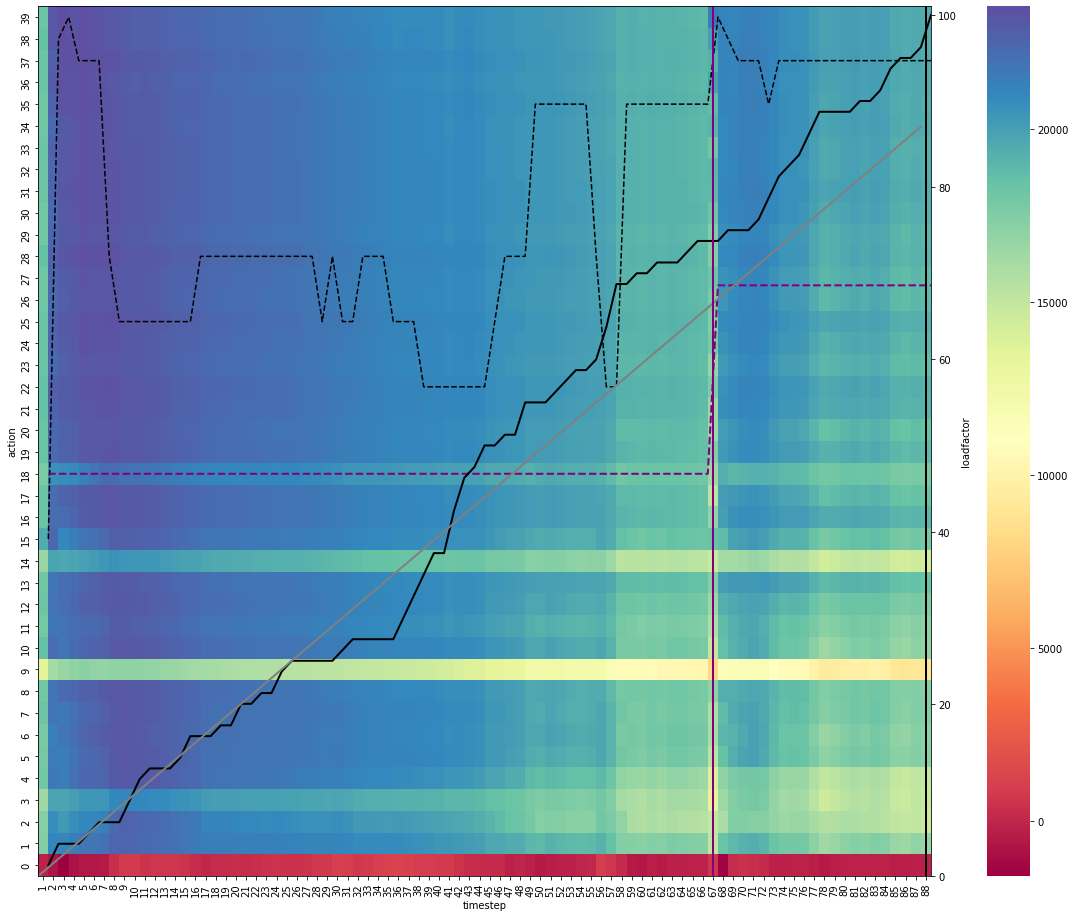

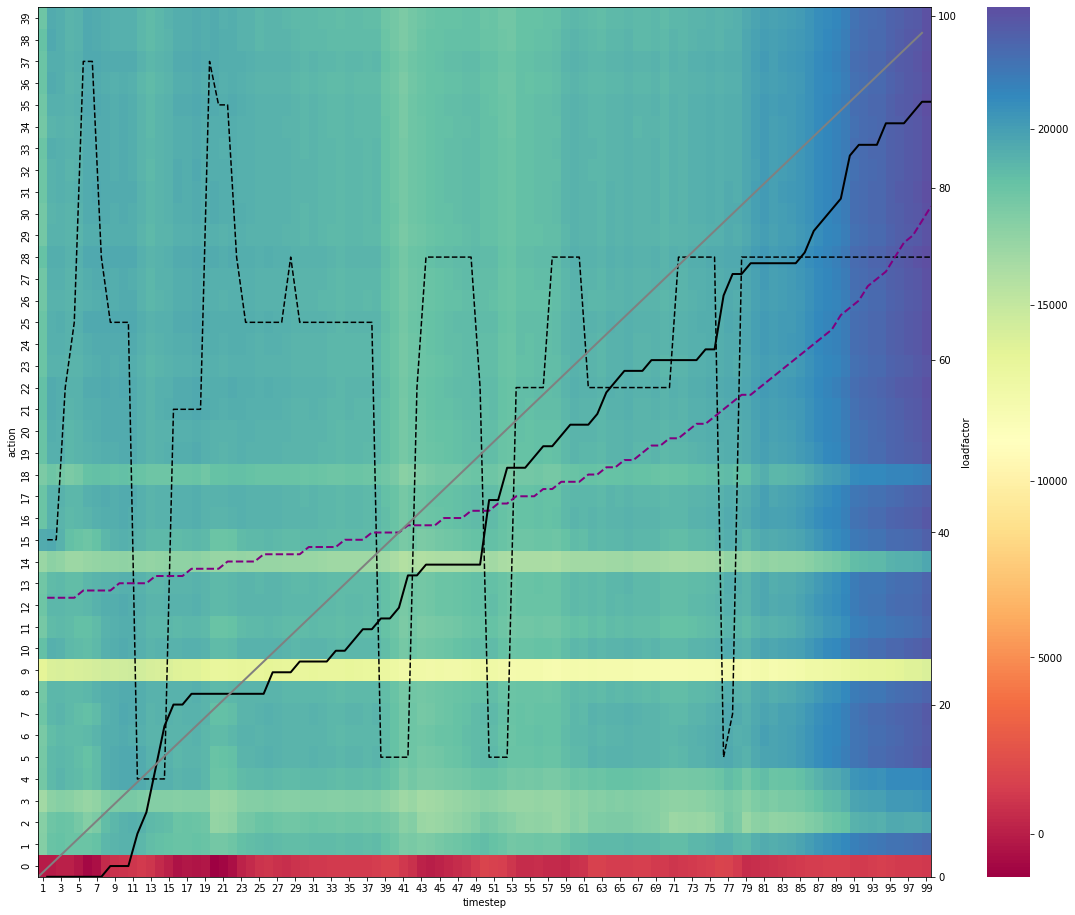

In [62]:
for i in range(5):
    plot_qlogits_heatmap(qpolicy, eval_env, dpc_game, i+1, i, None)

In [63]:
train_agent(2000 * 100, agent.collect_policy, collect_driver)
train_checkpointer.save(train_step_counter)


Iteration: 0, loss:1018.92
Train step counter: 600001, epsilon: 40.600
AverageReturn: 3193.592041015625

Iteration: 1000, loss:1080.92
Train step counter: 601001, epsilon: 40.501
AverageReturn: 1915.6783447265625

Iteration: 2000, loss:1131.31
Train step counter: 602001, epsilon: 40.402
AverageReturn: 2664.990234375

Iteration: 3000, loss:441.25
Train step counter: 603001, epsilon: 40.303
AverageReturn: 2466.360107421875

Iteration: 4000, loss:148.52
Train step counter: 604001, epsilon: 40.204
AverageReturn: 1160.118408203125

Iteration: 5000, loss:832.44
Train step counter: 605001, epsilon: 40.105
AverageReturn: 2907.98583984375

Iteration: 6000, loss:698.58
Train step counter: 606001, epsilon: 40.006
AverageReturn: 1641.1263427734375

Iteration: 7000, loss:896.41
Train step counter: 607001, epsilon: 39.907
AverageReturn: 1471.406494140625

Iteration: 8000, loss:310.62
Train step counter: 608001, epsilon: 39.808
AverageReturn: 2047.313720703125

Iteration: 9000, loss:693.80
Train ste


Iteration: 77000, loss:409.74
Train step counter: 677001, epsilon: 32.977
AverageReturn: 1619.801513671875

Iteration: 78000, loss:979.14
Train step counter: 678001, epsilon: 32.878
AverageReturn: 1781.2701416015625

Iteration: 79000, loss:763.32
Train step counter: 679001, epsilon: 32.779
AverageReturn: 2014.260986328125

Iteration: 80000, loss:1414.21
Train step counter: 680001, epsilon: 32.680
AverageReturn: 2466.50390625

Iteration: 81000, loss:166.53
Train step counter: 681001, epsilon: 32.581
AverageReturn: 2859.82568359375

Iteration: 82000, loss:314.98
Train step counter: 682001, epsilon: 32.482
AverageReturn: 2642.21142578125

Iteration: 83000, loss:596.45
Train step counter: 683001, epsilon: 32.383
AverageReturn: 1759.857421875

Iteration: 84000, loss:278.35
Train step counter: 684001, epsilon: 32.284
AverageReturn: 1799.1279296875

Iteration: 85000, loss:622.93
Train step counter: 685001, epsilon: 32.185
AverageReturn: 1933.3902587890625

Iteration: 86000, loss:373.85
Train

KeyboardInterrupt: 

In [ ]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'

    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, None)
    plot_reward_per_period(dpc_game.competition_results_df, competition_id, selling_season, None)

In [ ]:
for i in range(5):
    plot_qlogits_heatmap(qpolicy, eval_env, dpc_game, i+1, i, None)

In [ ]:
# Plot and save the competition results
revenue_ps = dpc_game.competition_results_df.groupby('selling_season')['revenue'].sum().reset_index()

plt.figure(figsize=(16, 6))
plt.title('Total revenue per season')
sns.lineplot(x=revenue_ps['selling_season'], y=revenue_ps['revenue'].astype(int))
sns.regplot(x=revenue_ps['selling_season'], y=revenue_ps['revenue'].astype(int), ci=False, scatter=False)
plt.grid()

In [ ]:
# Plot and save the competition results
reward_ps = dpc_game.competition_results_df.groupby('selling_season')['reward'].sum().reset_index()

plt.figure(figsize=(16, 6))
plt.title('Total reward per season')
sns.lineplot(x=reward_ps['selling_season'], y=reward_ps['reward'].astype(int))
sns.regplot(x=reward_ps['selling_season'], y=reward_ps['reward'].astype(int), ci=False, scatter=False)
plt.grid()

In [ ]:
# Plot and save the sell out period per season
sell_out_day = dpc_game.competition_results_df.groupby('selling_season')['selling_period'].max().reset_index()

plt.figure(figsize=(16,6))
plt.title('Sellout day per season')
sns.lineplot(x=sell_out_day['selling_season'], y=sell_out_day['selling_period'])
sns.regplot(x=sell_out_day['selling_season'], y=sell_out_day['selling_period'], ci=False, scatter=False)
plt.grid()

In [ ]:
# Also plot the total seats sold per season
demand_ps = dpc_game.competition_results_df.groupby('selling_season')['demand'].sum().reset_index()

plt.figure(figsize=(16,6))
plt.title('Total seats sold per season')
sns.lineplot(x=demand_ps['selling_season'], y=demand_ps['demand'].astype(int))
plt.grid()

In [ ]:
dpc_game.competition_results_df.to_csv('outputs/competition_results_df.csv', index=False)